In [360]:
# Importation des bibliothèques principales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prétraitement des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder

# Validation croisée et optimisation des hyperparamètres
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Modèles d'apprentissage automatique
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier

#Séléction des variables
from sklearn.inspection import permutation_importance


# Évaluation des performances
from sklearn.metrics import roc_auc_score


pd.options.mode.chained_assignment = None 


In [361]:
df=pd.read_csv("data/train.csv")
test_final = pd.read_csv('data/test.csv')

In [362]:
test_final_for_id = pd.read_csv('data/test.csv')

# EDA


### Information générale

In [363]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


##### On supprime 3 colonnes qui ne sont pas utiles pour notre analyse : "id", "CustomerId" et "Surname". On les élimine des deux datasets : train et test.

In [364]:
# On observe qu'il y a 3 colonnes qui ne sont pas utiles pour l'analyse, on les élimine des deux datasets : train et test
df=df.drop(columns=["id","CustomerId","Surname"])
test_final = test_final.drop(columns=["id","CustomerId","Surname"])

In [365]:
df.shape

(15000, 11)

In [366]:
test_final.shape

(10000, 10)

In [367]:
# Il n'y a pas de valeurs manquantes dans le dataset train
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [368]:
# Il n'y a pas de valeurs manquantes dans le dataset test
test_final.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

##### On a un dataset train qui contient 15000 observations et 11 variables après la suppression des variables "id", "CustomerId" et "Surname". Le dataset test contient 10000 observations et 10 variables car la variable cible "Exited n'y est pas. Il n'y a pas de valeurs manquantes.

In [369]:
# On vérifie s'il y a des doublons pour train 
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [370]:
# On vérifie s'il y a des doublons pour test 
duplicates = test_final.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


##### On observe qu'il n'y a pas de doublons, ni dans le train, ni dans le test.

In [371]:
df.dtypes

CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

In [372]:
test_final.dtypes

CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

##### On observe que notre dataset contient deux variables catégorielles ("Geography" et "Gender") sous forme de object. On a 8 variables numériques. Certaines variables float sont en réalité int, notamment "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember", "Exited" : elles ont uniquement des valeurs entières. Tel est aussi le cas pour "Age" et "CreditScore" mais on va les considérer des variables plutôt continues au vu de leur sens. La variable cible est une variable binaire codée en 0/1.

In [373]:
# Fonction pour transformer certaines colonnes float en int
def float_to_int(df, col):
    df[col]=df[col].astype('int64')
    return df

In [374]:
# On transforme ces colonnes float en int dans le train
colonnes_int_df=["Tenure","NumOfProducts","HasCrCard","IsActiveMember","Exited"]
float_to_int(df,colonnes_int_df)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,683.0,Germany,Male,49.0,7,123837.86,2,1,1,138700.75,1
1,608.0,France,Female,30.0,10,0.00,2,1,1,146723.72,0
2,539.0,France,Female,32.0,8,0.00,1,1,1,94873.60,0
3,530.0,Spain,Female,39.0,8,0.00,2,0,0,177896.93,0
4,613.0,France,Female,45.0,10,0.00,2,1,1,116748.14,0
...,...,...,...,...,...,...,...,...,...,...,...
14995,681.0,Spain,Male,31.0,1,0.00,2,1,1,125445.80,0
14996,549.0,Germany,Male,34.0,7,134464.58,1,1,0,126535.92,0
14997,550.0,France,Female,46.0,5,0.00,2,1,1,133897.32,0
14998,647.0,France,Female,25.0,4,141616.55,2,1,0,187597.98,0


In [375]:
# On transforme ces colonnes float en int dans le test
colonnes_int_test=["Tenure","NumOfProducts","HasCrCard","IsActiveMember"]  
float_to_int(test_final,colonnes_int_test)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,591.0,Germany,Female,32.0,2,106881.50,2,1,0,122810.53
1,553.0,Spain,Male,37.0,2,0.00,2,1,0,63736.17
2,646.0,France,Female,29.0,7,0.00,2,1,0,121866.87
3,603.0,Germany,Male,49.0,8,131394.56,1,0,1,147059.28
4,645.0,Spain,Female,39.0,3,0.00,2,1,0,129975.94
...,...,...,...,...,...,...,...,...,...,...
9995,694.0,Spain,Male,41.0,6,0.00,2,0,0,171378.77
9996,614.0,France,Female,55.0,8,157597.61,1,1,0,70974.13
9997,589.0,France,Male,41.0,4,0.00,2,1,1,123475.88
9998,543.0,Germany,Male,33.0,2,151659.52,1,1,1,86911.49


In [376]:
# Colonnes numériques et catégorielles
categorical_columns=df.select_dtypes(include="object").columns
numerical_columns=df.select_dtypes(include="number").columns
print(f"categorical columns: {categorical_columns}\n numerical columns:{numerical_columns}")

categorical columns: Index(['Geography', 'Gender'], dtype='object')
 numerical columns:Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [377]:
def show_value_counts(df, cat_columns, num_columns):
    """
    Affiche les valeurs uniques et leurs fréquences pour les colonnes catégorielles 
    et les statistiques descriptives pour les colonnes numériques.
    """

    print("\n--- Valeurs pour les colonnes catégorielles ---\n")
    for col in cat_columns:
        print(f"Valeurs uniques pour '{col}':")
        print(df[col].value_counts())
        print("\n")

    print("\n--- Statistiques pour les colonnes numériques ---\n")
    for col in num_columns:
        print(f"Statistiques descriptives pour '{col}':")
        print(df[col].describe())
        print("\n")


show_value_counts(df, categorical_columns, numerical_columns)



--- Valeurs pour les colonnes catégorielles ---

Valeurs uniques pour 'Geography':
Geography
France     9048
Spain      3257
Germany    2695
Name: count, dtype: int64


Valeurs uniques pour 'Gender':
Gender
Male      8422
Female    6578
Name: count, dtype: int64



--- Statistiques pour les colonnes numériques ---

Statistiques descriptives pour 'CreditScore':
count    15000.000000
mean       658.701800
std         80.238346
min        431.000000
25%        602.000000
50%        661.000000
75%        709.000000
max       4818.000000
Name: CreditScore, dtype: float64


Statistiques descriptives pour 'Age':
count    15000.000000
mean        37.660800
std          8.106408
min         18.000000
25%         32.000000
50%         37.000000
75%         42.000000
max         72.000000
Name: Age, dtype: float64


Statistiques descriptives pour 'Tenure':
count    15000.000000
mean         5.038800
std          2.810354
min          0.000000
25%          3.000000
50%          5.000000
75%      

### Distributions

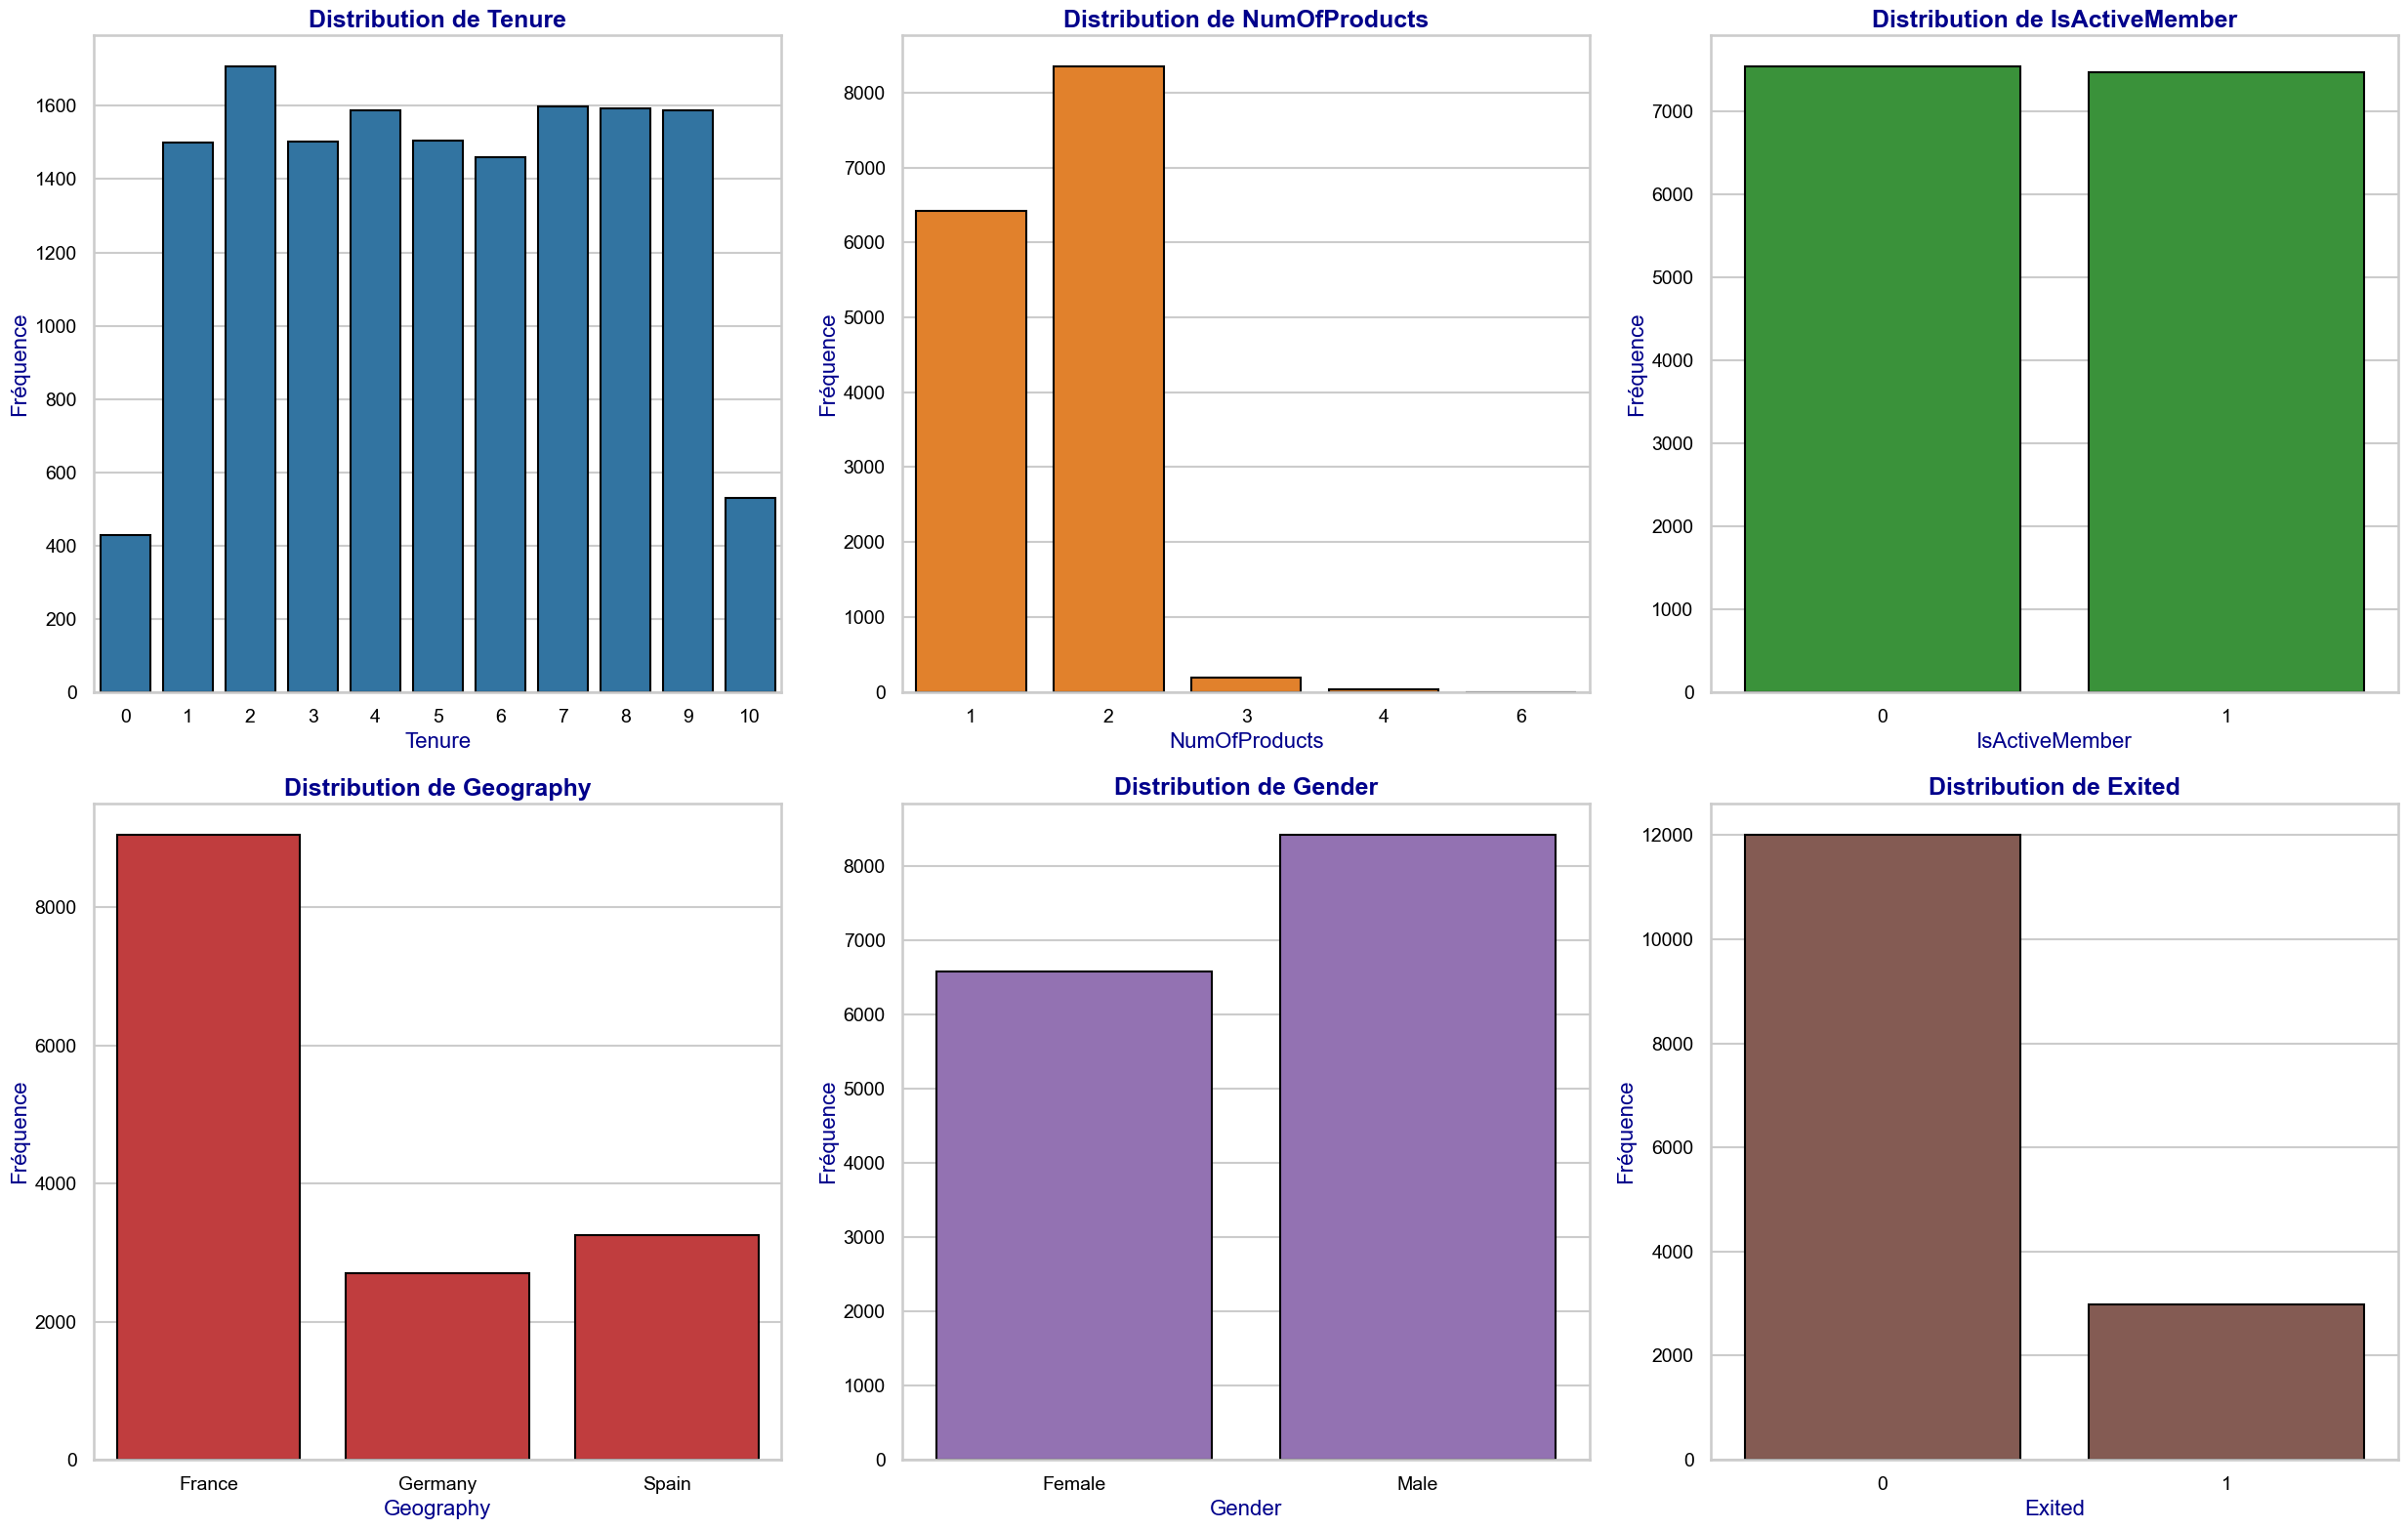

In [378]:
#Distributions pour les données train

# Colonnes discrètes à analyser
discrete_cat_columns = ["Tenure", "NumOfProducts", "IsActiveMember", "Geography", "Gender", "Exited"]

data = df  
sns.set_style("whitegrid")
sns.set_context("talk")  


fig, axes = plt.subplots(2, 3, figsize=(25, 16))  
axes = axes.flatten()  
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]  

for i, col in enumerate(discrete_cat_columns):
    value_counts = data[col].value_counts().sort_index()
    
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        color=palette[i % len(palette)],
        ax=axes[i],
        edgecolor="black"
    )
    
   
    axes[i].set_title(f'Distribution de {col}', fontsize=18, fontweight='bold', color="darkblue")
    axes[i].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i].set_ylabel('Fréquence', fontsize=16, color="darkblue")
    axes[i].tick_params(axis='both', which='major', labelsize=14, colors="black")

fig.patch.set_facecolor('white')  
plt.tight_layout()
plt.show()



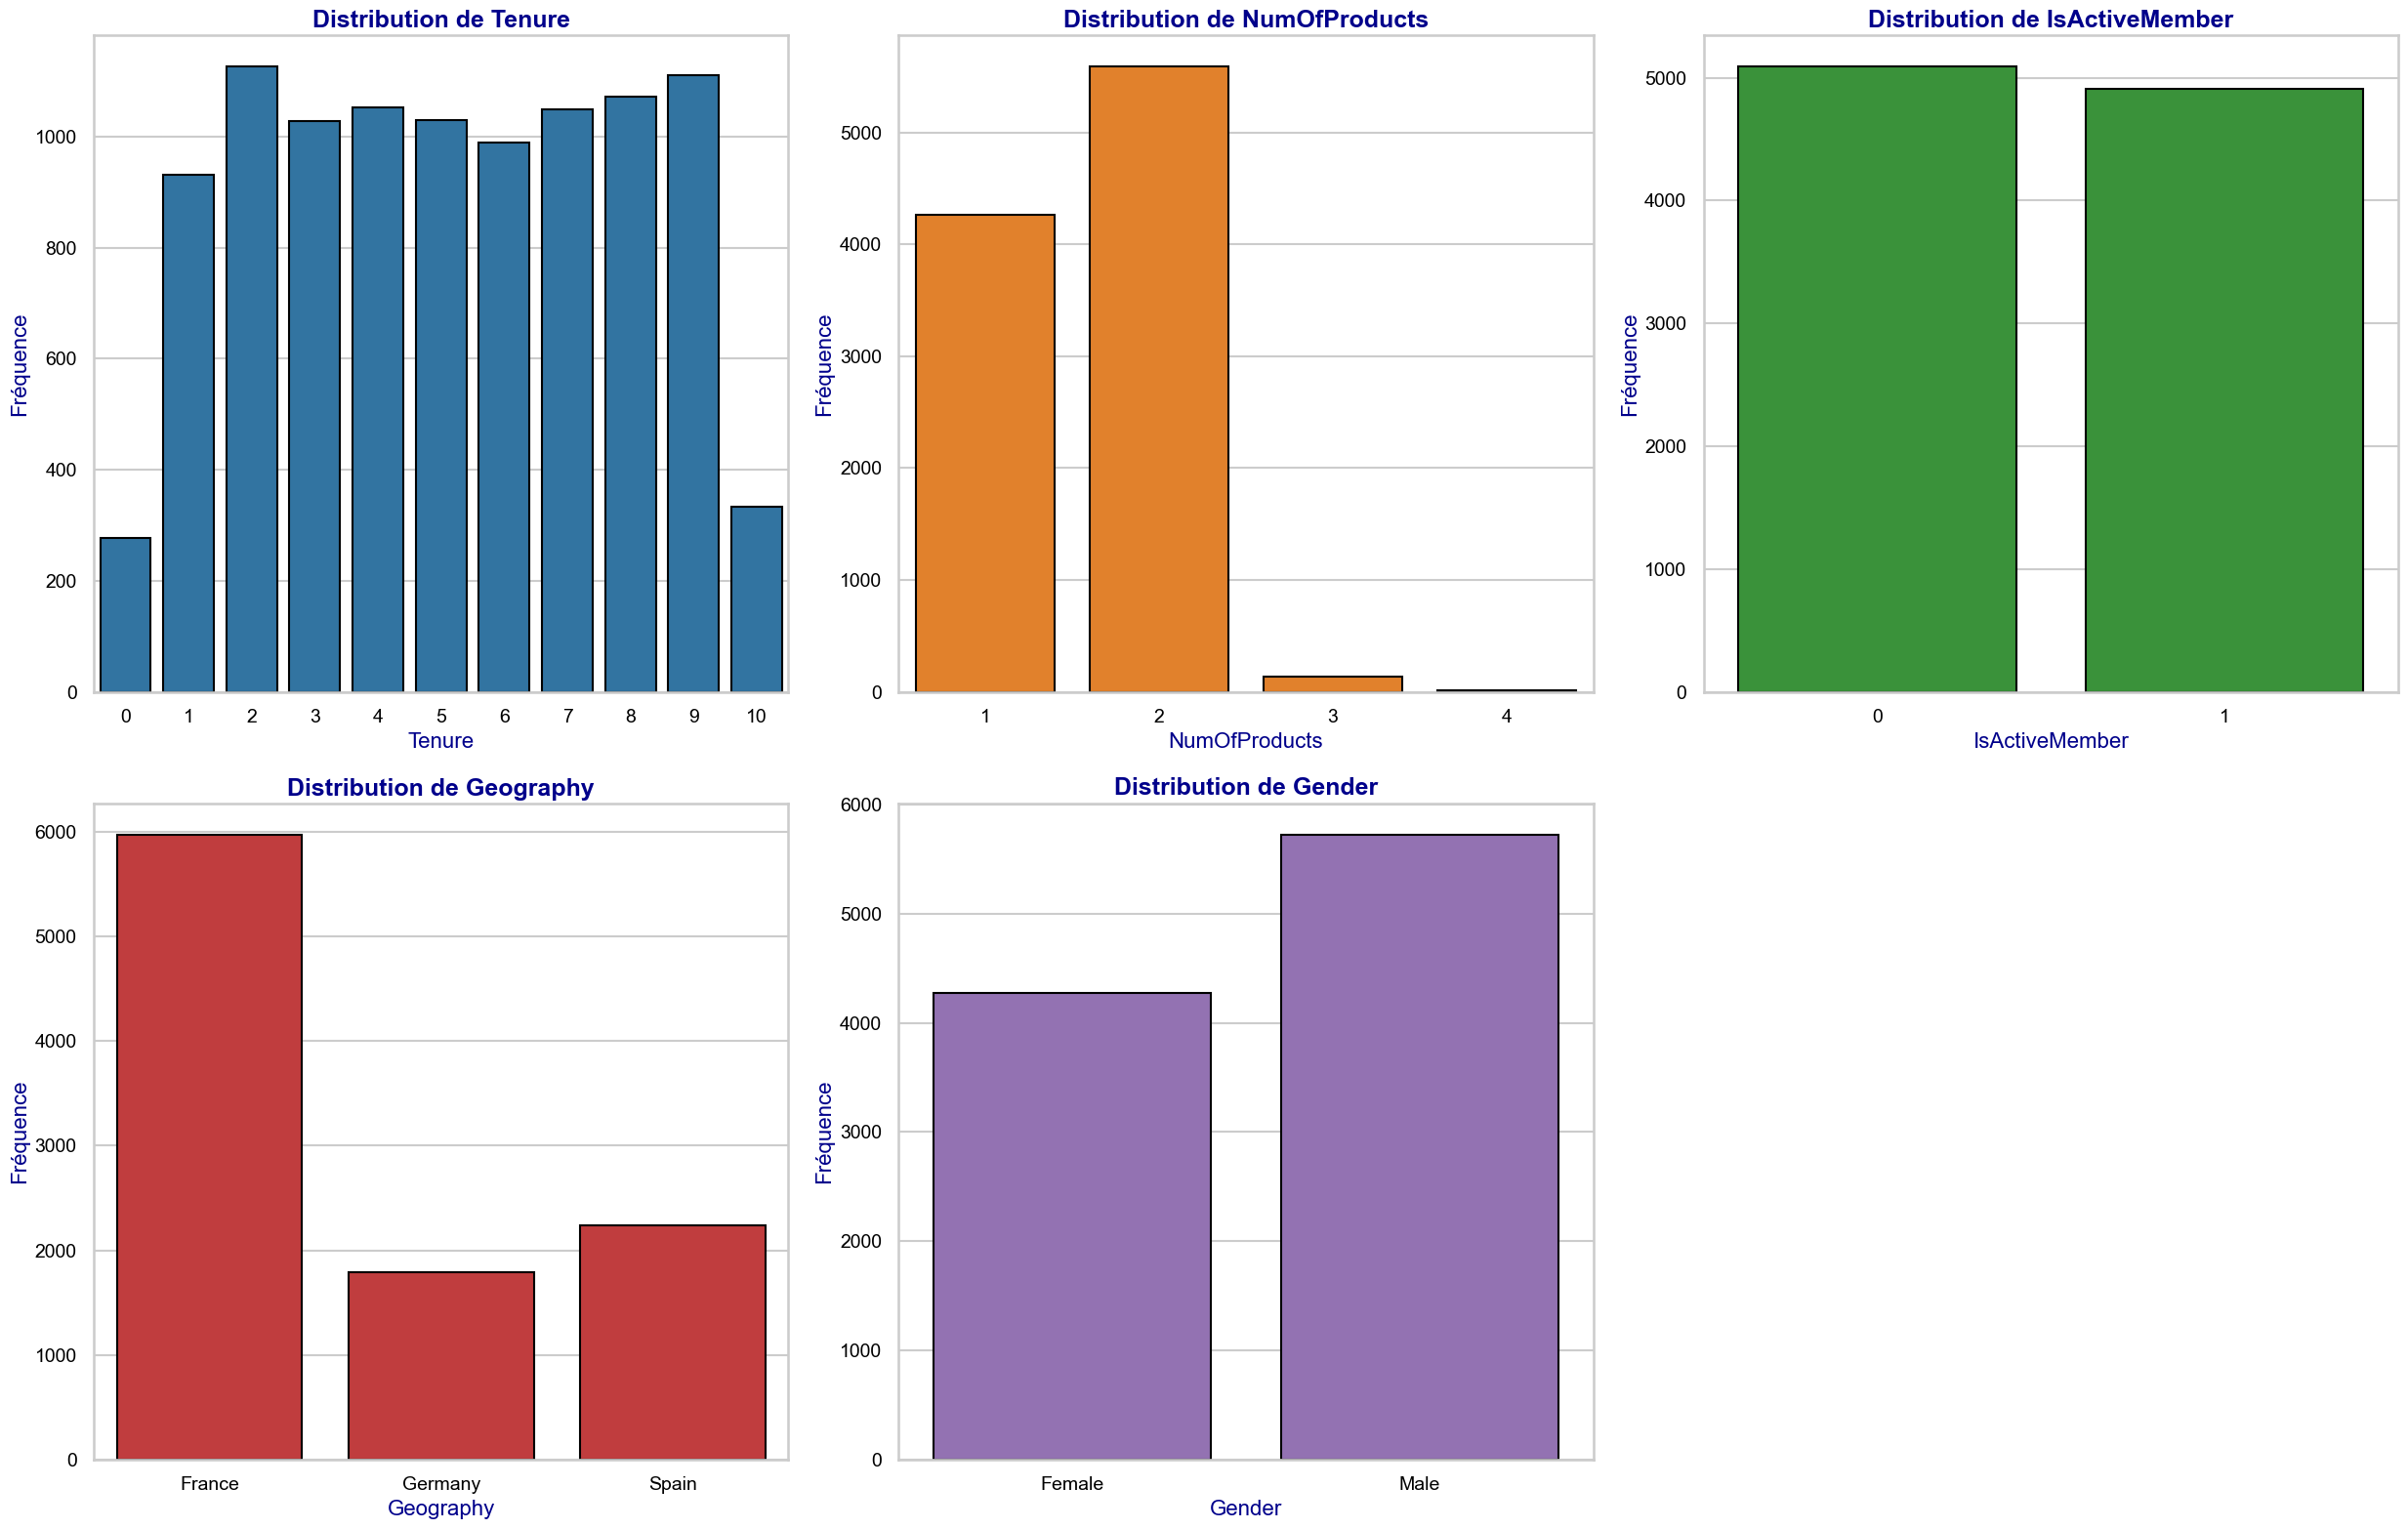

In [379]:
# Distributions pour les données test

# Colonnes discrètes à analyser 
discrete_cat_columns = ["Tenure", "NumOfProducts", "IsActiveMember", "Geography", "Gender"]

data = test_final  
sns.set_style("whitegrid")
sns.set_context("talk")  

# Calculer les lignes et colonnes nécessaires
n = len(discrete_cat_columns)
n_rows = (n // 3) + (n % 3 > 0)  
n_cols = min(n, 3)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 16))  
axes = axes.flatten()  
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]  

for i, col in enumerate(discrete_cat_columns):
    value_counts = data[col].value_counts().sort_index()
    
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        color=palette[i % len(palette)],
        ax=axes[i],
        edgecolor="black"
    )
    
    axes[i].set_title(f'Distribution de {col}', fontsize=18, fontweight='bold', color="darkblue")
    axes[i].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i].set_ylabel('Fréquence', fontsize=16, color="darkblue")
    axes[i].tick_params(axis='both', which='major', labelsize=14, colors="black")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

fig.patch.set_facecolor('white')  
plt.tight_layout()
plt.show()

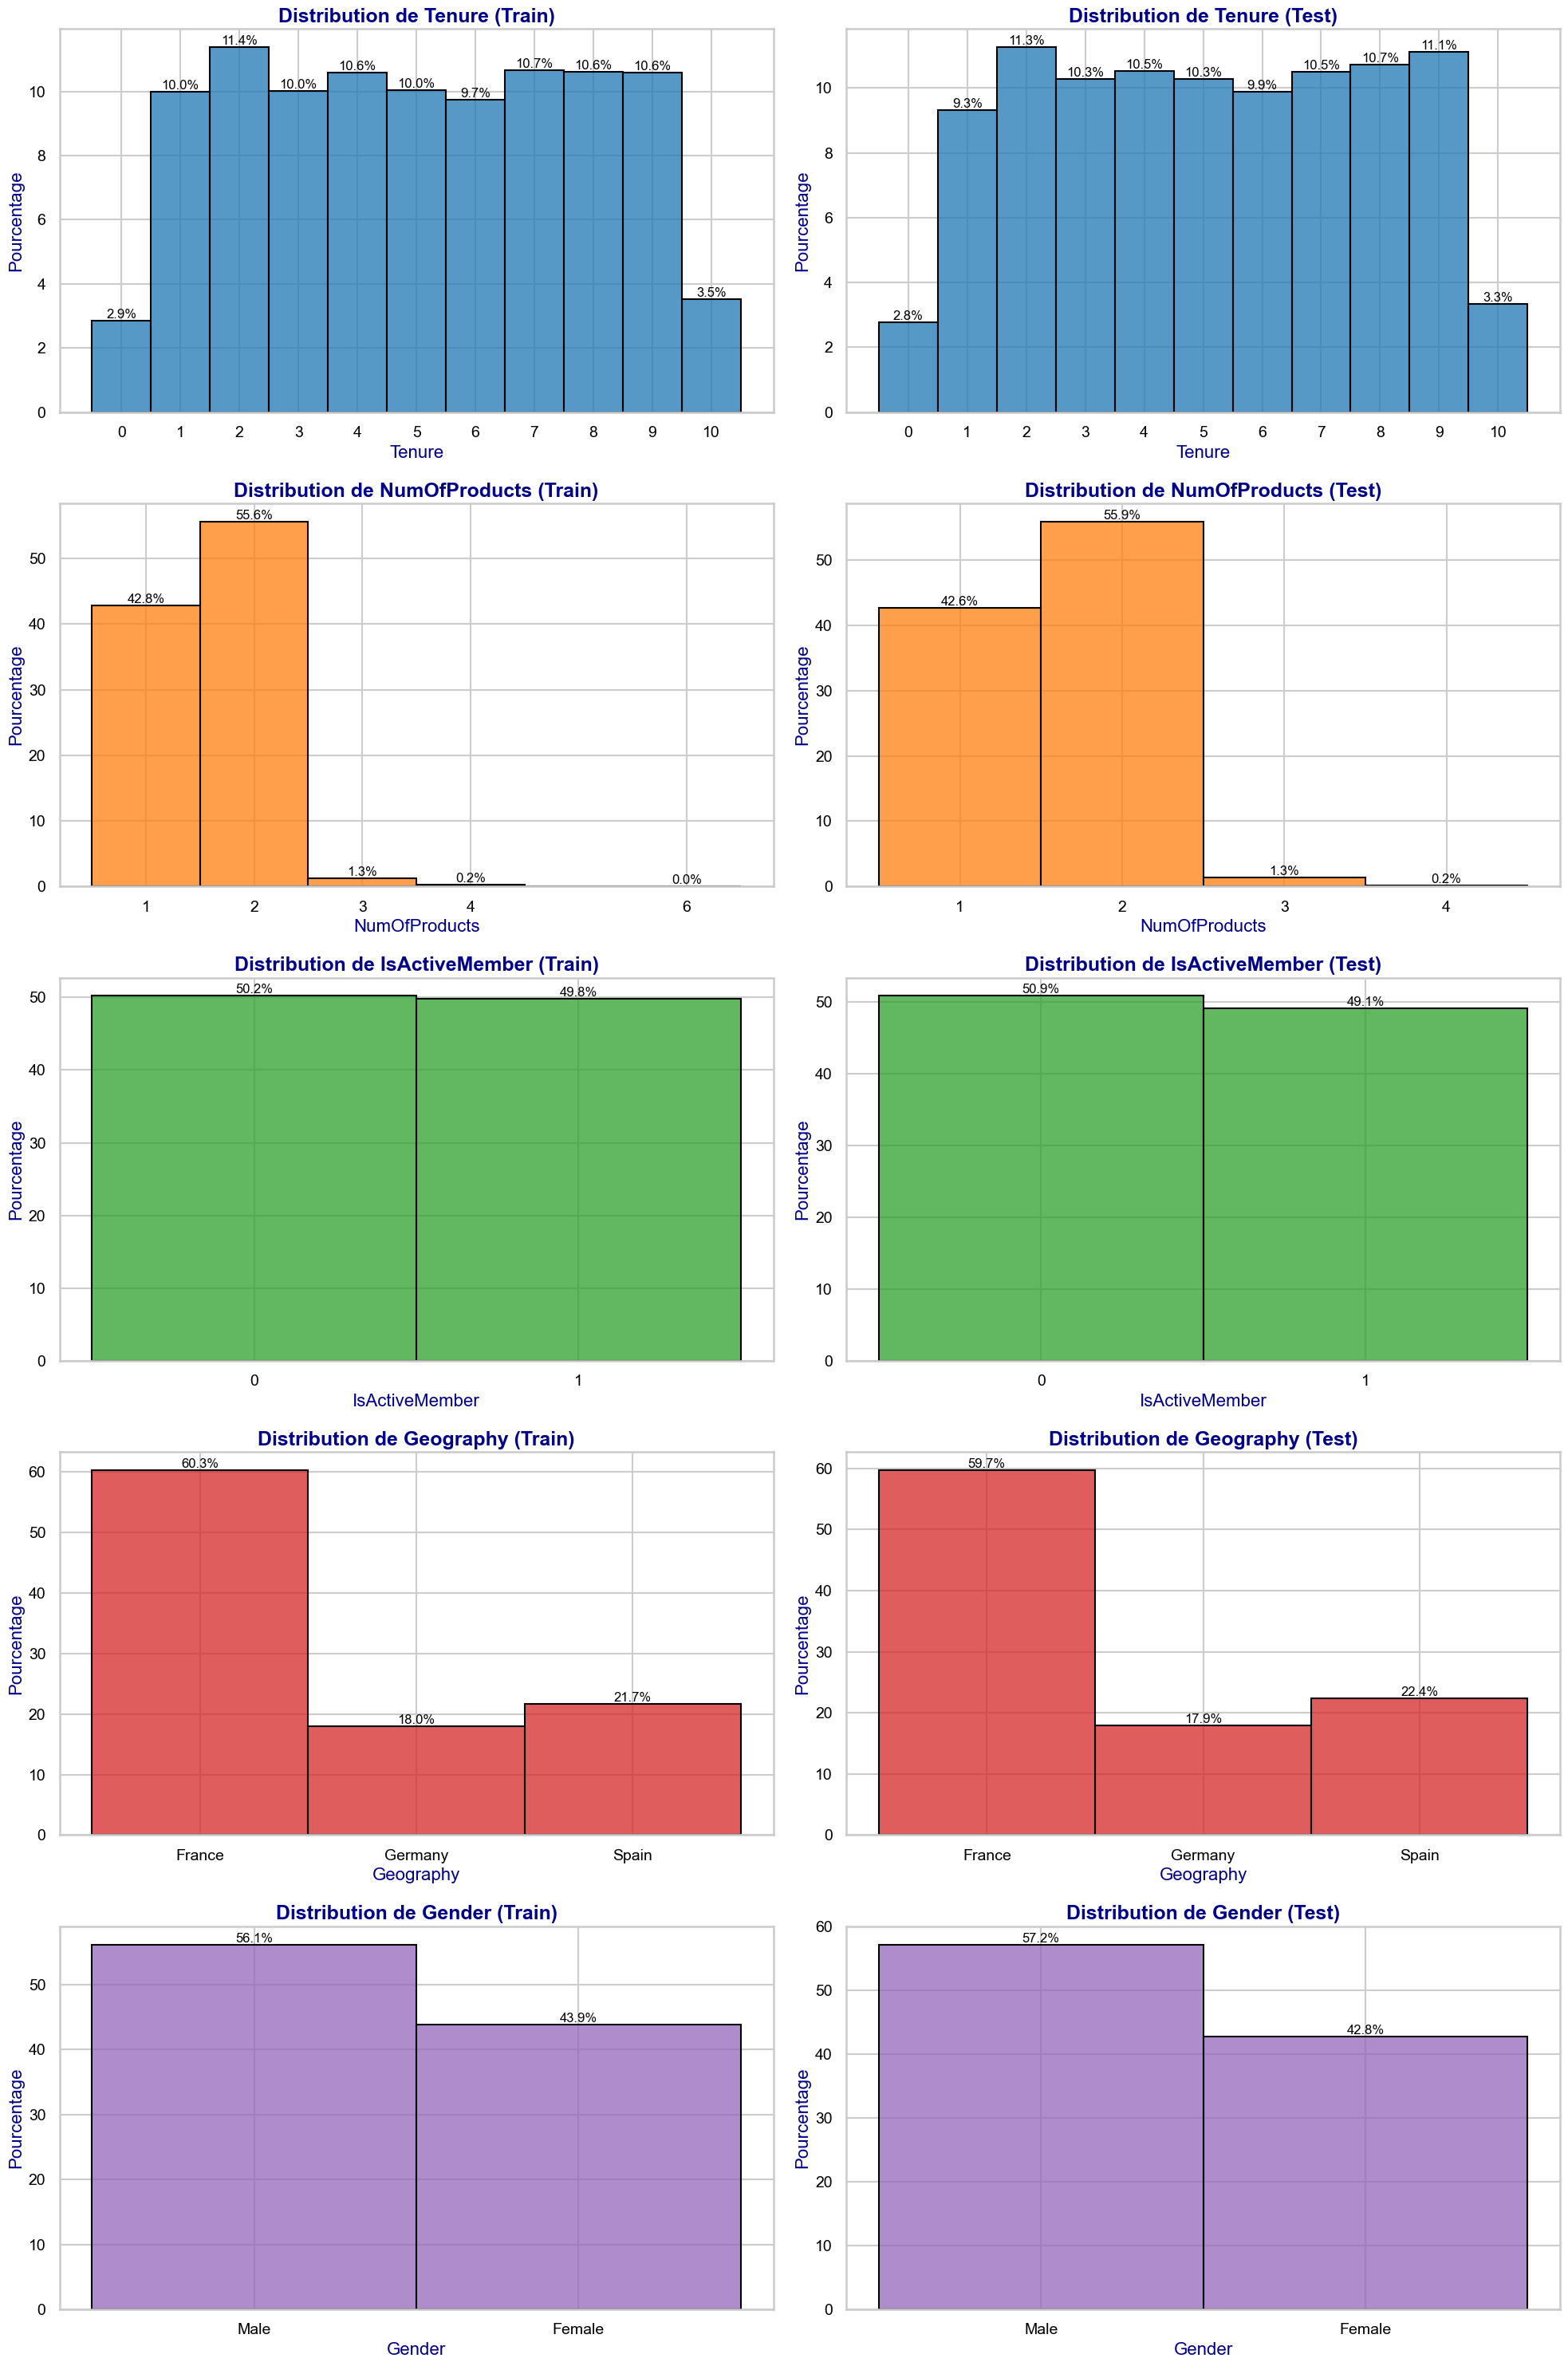

In [380]:
#Comparaison train/test

# Colonnes discrètes pour comparer entre les distribution des datasets train et test
discrete_columns = ["Tenure", "NumOfProducts", "IsActiveMember", "Geography", "Gender"]

order_geography = ['France', 'Germany', 'Spain']
order_gender = ['Male', 'Female']

df['Geography'] = pd.Categorical(df['Geography'], categories=order_geography, ordered=True)
test_final['Geography'] = pd.Categorical(test_final['Geography'], categories=order_geography, ordered=True)

df['Gender'] = pd.Categorical(df['Gender'], categories=order_gender, ordered=True)
test_final['Gender'] = pd.Categorical(test_final['Gender'], categories=order_gender, ordered=True)

sns.set_style("whitegrid")
sns.set_context("talk")


fig, axes = plt.subplots(len(discrete_columns), 2, figsize=(20, 6 * len(discrete_columns)))  

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for i, col in enumerate(discrete_columns):
    # Graphique pour le dataset 'df' (train)
    ax = sns.histplot(
        df[col],
        color=palette[i % len(palette)],
        ax=axes[i, 0],
        discrete=True,
        stat="percent",
        edgecolor="black",
    )
    axes[i, 0].set_title(f'Distribution de {col} (Train)', fontsize=18, fontweight='bold', color="darkblue")
    axes[i, 0].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i, 0].set_ylabel('Pourcentage', fontsize=16, color="darkblue")
    axes[i, 0].tick_params(axis='both', which='major', labelsize=14, colors="black")
    axes[i, 0].set_xticks(df[col].unique())
   

    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            ax.text(
                p.get_x() + p.get_width() / 2, 
                height, 
                f'{height:.1f}%',  
                ha='center', 
                va='bottom', 
                fontsize=12, 
                color='black'
            )

    # Graphique pour le dataset 'test'
    ax = sns.histplot(
        test_final[col],
        color=palette[i % len(palette)],
        ax=axes[i, 1],
        discrete=True,
        stat="percent",
        edgecolor="black",
    )
    axes[i, 1].set_title(f'Distribution de {col} (Test)', fontsize=18, fontweight='bold', color="darkblue")
    axes[i, 1].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i, 1].set_ylabel('Pourcentage', fontsize=16, color="darkblue")
    axes[i, 1].tick_params(axis='both', which='major', labelsize=14, colors="black")
    axes[i, 1].set_xticks(test_final[col].unique())
   

    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            ax.text(
                p.get_x() + p.get_width() / 2, 
                height, 
                f'{height:.1f}%',  
                ha='center', 
                va='bottom', 
                fontsize=12, 
                color='black'
            )

fig.patch.set_facecolor('white')  
plt.tight_layout()
plt.show()


In [381]:
df.NumOfProducts.value_counts()

NumOfProducts
2    8346
1    6426
3     190
4      37
6       1
Name: count, dtype: int64

In [382]:
test_final.NumOfProducts.value_counts()

NumOfProducts
2    5588
1    4261
3     133
4      18
Name: count, dtype: int64

##### On peut voir que les distributions de train et de test se ressemblent pour toutes les variables discrètes.
##### La distribution de Tenure est très similaire dans les datasets train et test.
##### Dans le dataset train on observe une fois la valeur 6 pour la variable "NumOfProducts" alors que dans la base de donnée test on a uniquement des valeurs 1-4. On a donc choisi de la remplacer par 4.
##### Les variable "IsActiveMember", "Gender" et "Geography" ont une distribution similaire dans les datasets train et test. Cependant, la modalité "France" pour la variable "Geography" est beaucoup plus fréquente que les modalités "Spain" et "Germany", elle est donc sur-représentée.

In [383]:
df.NumOfProducts = df.NumOfProducts.replace(6, 4)

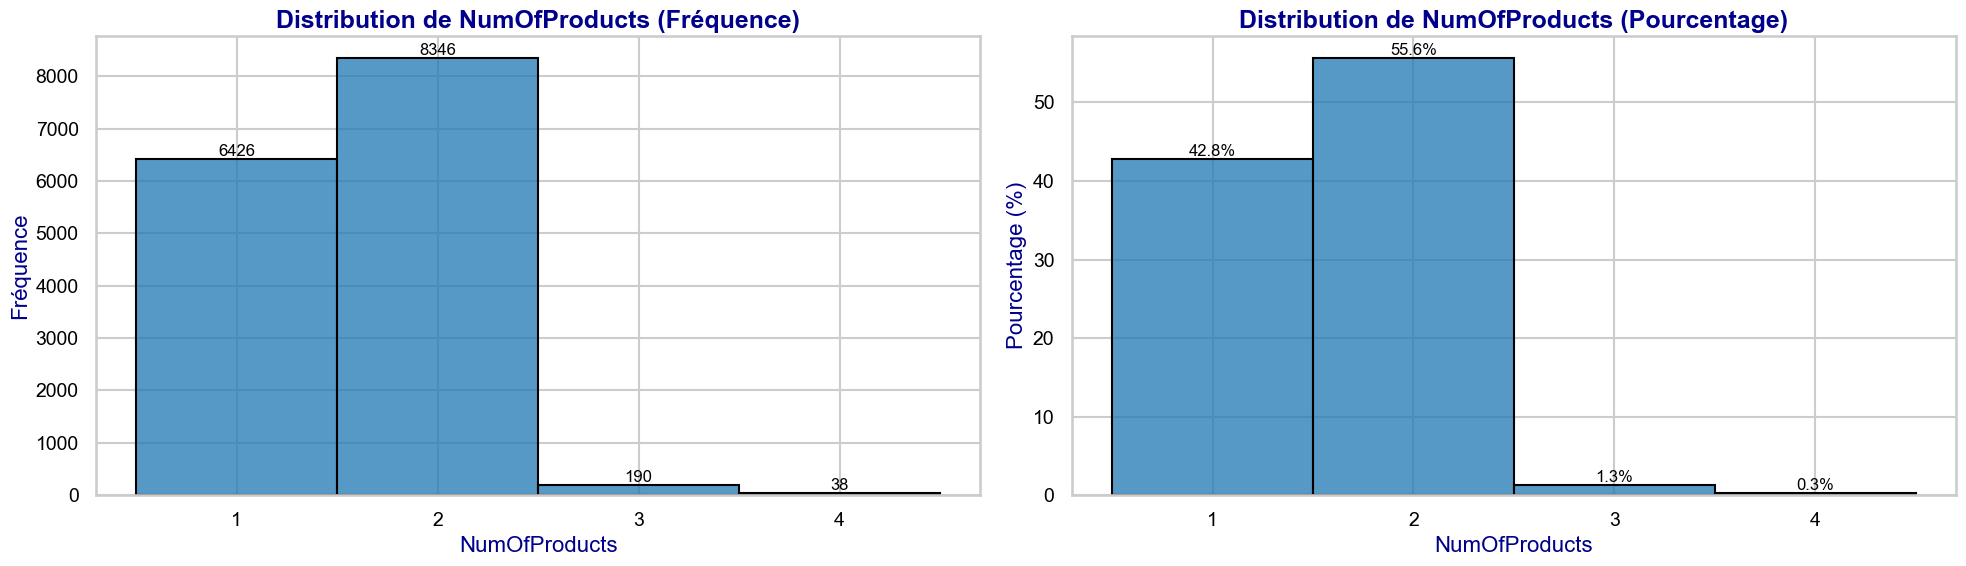

In [384]:
# Distribution de NumOfProducts dans le train après la suppression de la valeur aberrante, en fréquence absolue et en %

palette = ["#1f77b4"]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Graphique 1 : Fréquence brute
ax = sns.histplot(
    df["NumOfProducts"], 
    color=palette[0],  
    discrete=True,  
    stat="count",  
    edgecolor="black", 
    ax=axes[0]   
)
axes[0].set_title("Distribution de NumOfProducts (Fréquence)", fontsize=18, fontweight='bold', color="darkblue")
axes[0].set_xlabel("NumOfProducts", fontsize=16, color="darkblue")
axes[0].set_ylabel("Fréquence", fontsize=16, color="darkblue")
axes[0].tick_params(axis='both', which='major', labelsize=14, colors="black")
axes[0].set_xticks(sorted(df["NumOfProducts"].unique()))


for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:.0f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black')

# Graphique 2 : Pourcentage
ax2 = sns.histplot(
    df["NumOfProducts"], 
    color=palette[0],  
    discrete=True,  
    stat="percent",  
    edgecolor="black", 
    ax=axes[1] 
)
axes[1].set_title("Distribution de NumOfProducts (Pourcentage)", fontsize=18, fontweight='bold', color="darkblue")
axes[1].set_xlabel("NumOfProducts", fontsize=16, color="darkblue")
axes[1].set_ylabel("Pourcentage (%)", fontsize=16, color="darkblue")
axes[1].tick_params(axis='both', which='major', labelsize=14, colors="black")
axes[1].set_xticks(sorted(df["NumOfProducts"].unique()))


for p in ax2.patches:
    height = p.get_height()
    if height > 0: 
        ax2.annotate(f'{height:.1f}%', 
                     (p.get_x() + p.get_width() / 2, height), 
                     ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


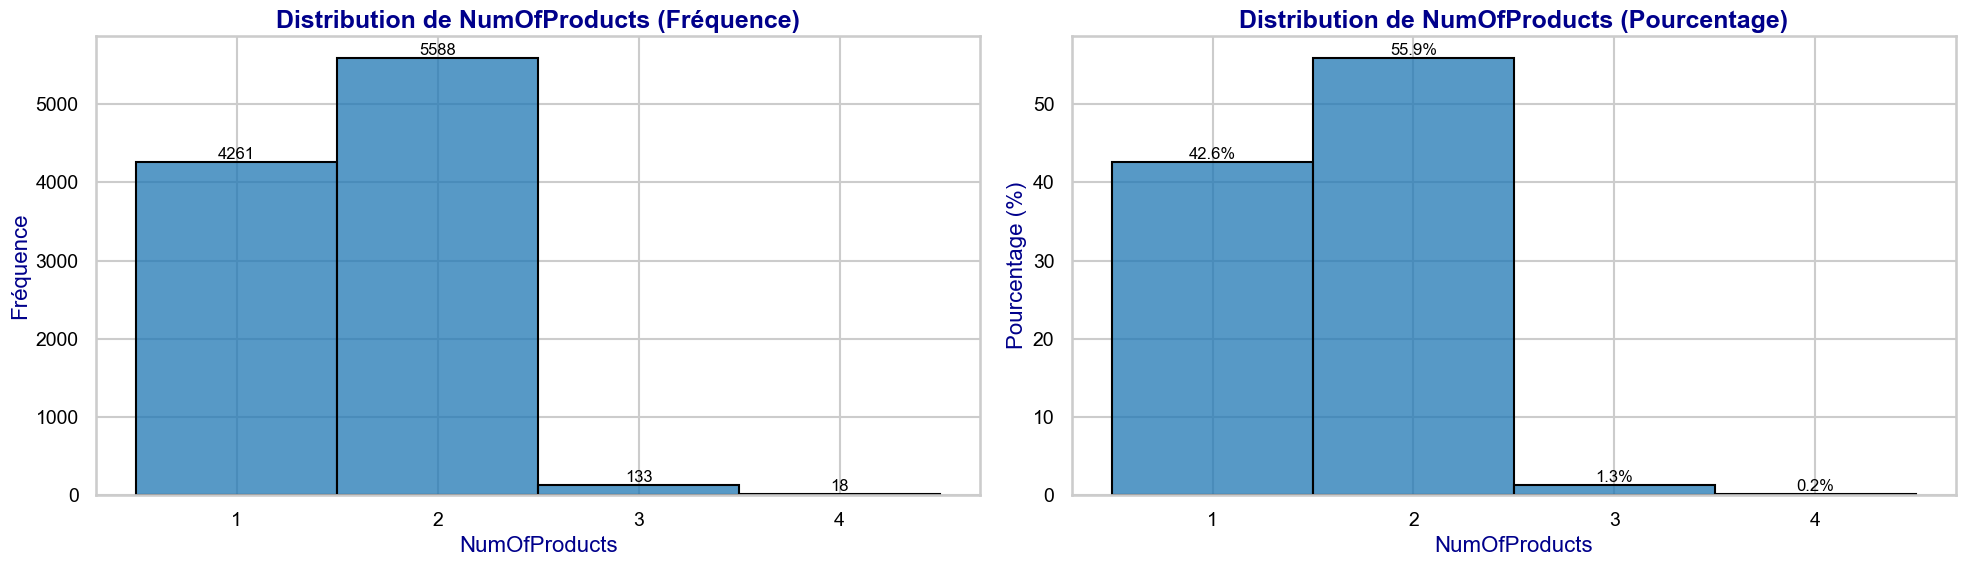

In [385]:
# Distribution de NumOfProducts dans le test après la suppression de la valeur aberrante, en fréquence absolue et en % (pour comparer avec le train)
palette = ["#1f77b4"]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Graphique 1 : Fréquence brute
ax = sns.histplot(
    test_final["NumOfProducts"], 
    color=palette[0],  
    discrete=True,  
    stat="count",  
    edgecolor="black", 
    ax=axes[0]   
)
axes[0].set_title("Distribution de NumOfProducts (Fréquence)", fontsize=18, fontweight='bold', color="darkblue")
axes[0].set_xlabel("NumOfProducts", fontsize=16, color="darkblue")
axes[0].set_ylabel("Fréquence", fontsize=16, color="darkblue")
axes[0].tick_params(axis='both', which='major', labelsize=14, colors="black")
axes[0].set_xticks(sorted(test_final["NumOfProducts"].unique()))


for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{height:.0f}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=12, color='black')

# Graphique 2 : Pourcentage
ax2 = sns.histplot(
    test_final["NumOfProducts"], 
    color=palette[0],  
    discrete=True,  
    stat="percent",  
    edgecolor="black", 
    ax=axes[1] 
)
axes[1].set_title("Distribution de NumOfProducts (Pourcentage)", fontsize=18, fontweight='bold', color="darkblue")
axes[1].set_xlabel("NumOfProducts", fontsize=16, color="darkblue")
axes[1].set_ylabel("Pourcentage (%)", fontsize=16, color="darkblue")
axes[1].tick_params(axis='both', which='major', labelsize=14, colors="black")
axes[1].set_xticks(sorted(test_final["NumOfProducts"].unique()))


for p in ax2.patches:
    height = p.get_height()
    if height > 0: 
        ax2.annotate(f'{height:.1f}%', 
                     (p.get_x() + p.get_width() / 2, height), 
                     ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()


##### Le changement a bien rétabli les distributions pour la variable "NumOfProducts", il n'y a plus de différences à noter entre le train et le test.

In [386]:
# On calcule les stat en % de "Exited" pour chaque modalité de la variable 'Geography'
stats = df.groupby('Geography')['Exited'].value_counts(normalize=True).unstack(fill_value=0) * 100
stats.columns = ['Restent (%)', 'Quittent (%)']
print(stats)

           Restent (%)  Quittent (%)
Geography                           
France       84.582228     15.417772
Germany      59.925788     40.074212
Spain        84.187903     15.812097


/var/folders/15/sbz0kr8n2j776rlwn0h0nb700000gn/T/ipykernel_20121/2206557808.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby('Geography')['Exited'].value_counts(normalize=True).unstack(fill_value=0) * 100


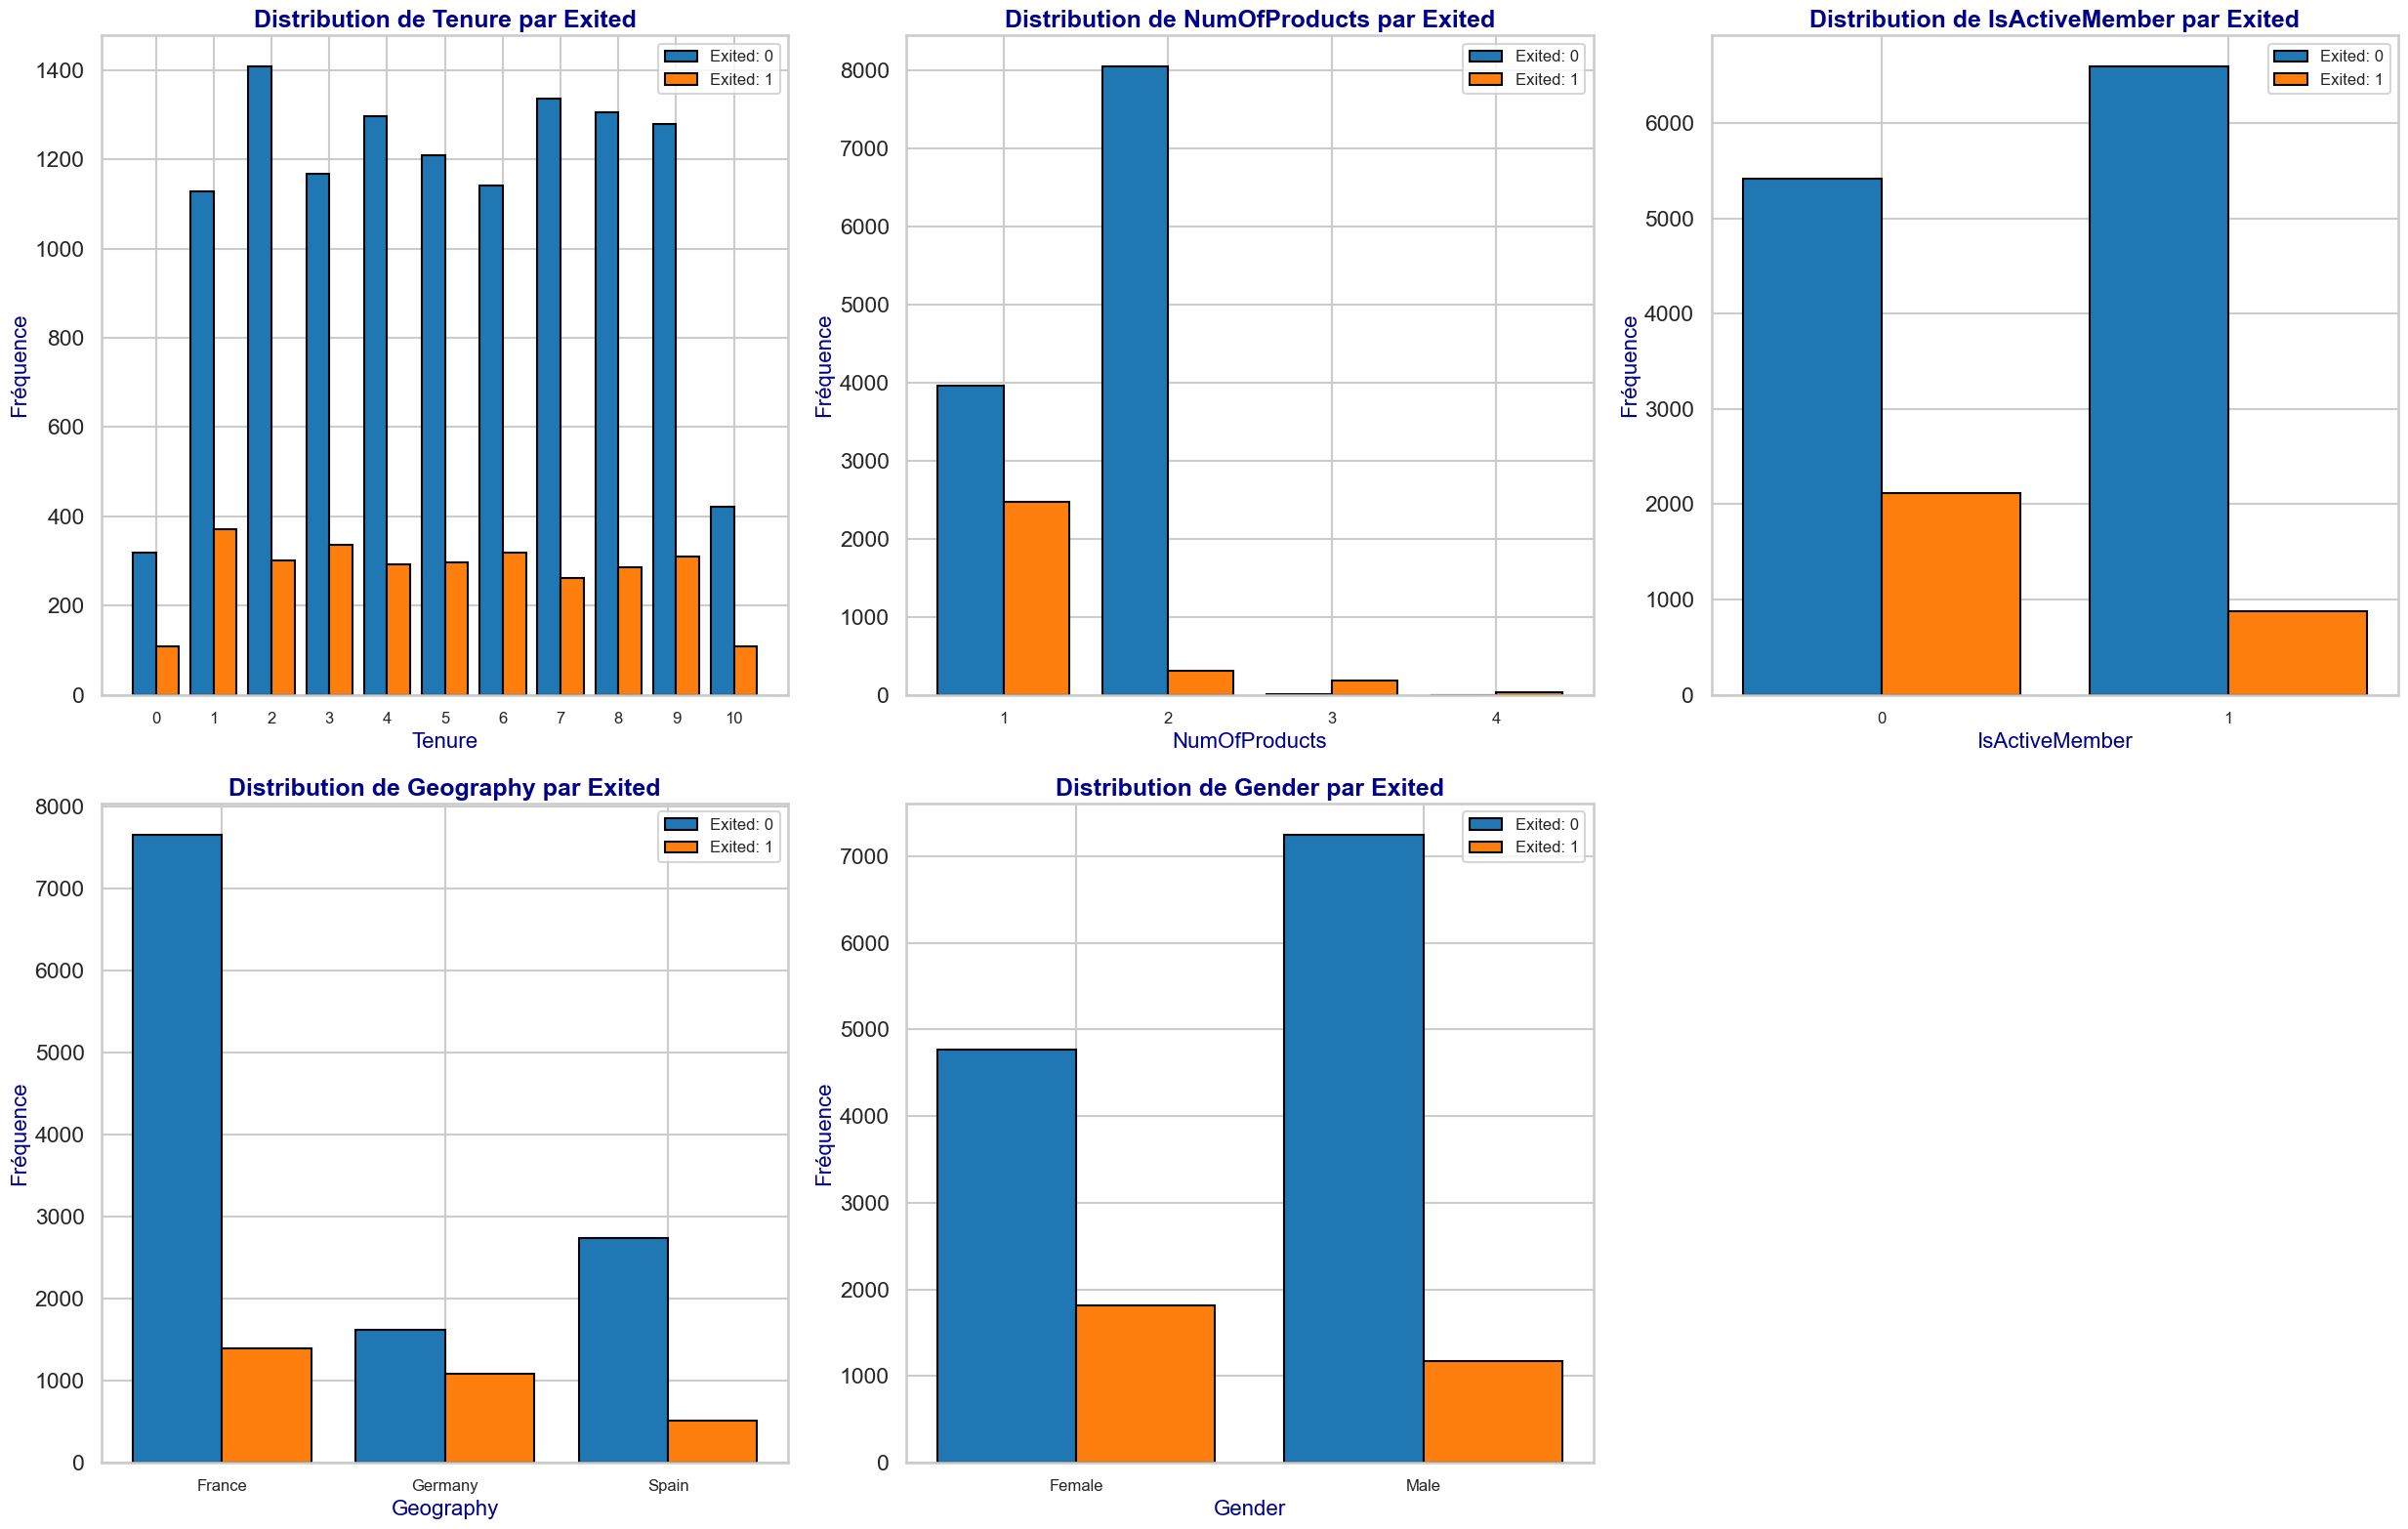

In [387]:
# Distribution des variables discrètes en fonction de target dans le train

discrete_cat_columns=["Tenure","NumOfProducts","IsActiveMember","Geography","Gender"]

fig, axes = plt.subplots(2, 3, figsize=(25, 16))
axes = axes.flatten()

colors = ["#1f77b4", "#ff7f0e"]  

for i, col in enumerate(discrete_cat_columns):
    ax = axes[i]
    unique_vals = sorted(df[col].unique()) 
    exited_0 = df[df['Exited'] == 0][col].value_counts().reindex(unique_vals, fill_value=0)
    exited_1 = df[df['Exited'] == 1][col].value_counts().reindex(unique_vals, fill_value=0)
    width = 0.4
    indices = range(len(unique_vals))
    ax.bar([x - width / 2 for x in indices], exited_0, width=width, color=colors[0], label="Exited: 0", edgecolor="black")
    ax.bar([x + width / 2 for x in indices], exited_1, width=width, color=colors[1], label="Exited: 1", edgecolor="black")

    ax.set_xticks(indices)
    ax.set_xticklabels(unique_vals, fontsize=12)
    ax.set_title(f"Distribution de {col} par Exited", fontsize=18, fontweight='bold', color="darkblue")
    ax.set_xlabel(col, fontsize=16, color="darkblue")
    ax.set_ylabel("Fréquence", fontsize=16, color="darkblue")
    ax.legend(fontsize=12)


for j in range(len(discrete_cat_columns), len(axes)):
    fig.delaxes(axes[j])


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

##### Pour la variable "Tenure", il n'y a pas forcément de pattern à déduire.
##### Cependant, ce qui est intéressant à souligner c'est que plus de clients utilisant un seul produit quittent que ceux utilisant 2 produits et ce, malgré le fait qu'il y a bcp plus de personnes utilisant 2 produits qu'un seul. On s'attendrait donc proportionnellement à voir davantage de personnes quitter. Cela pourrait se traduire par une meilleure fidélité de la part des clients utilisant deux produits ou bien par la difficulté de déplacer les fonds vers une autre banque/conditions juridiques difficiles/potentielles pertes d'argent etc.
##### Concernant la variable "IsActiveMember", on observe le pattern suivant : les gens quittent plus quand ils ne sont pas actifs et ils quittent moins s'ils sont actifs, ce qui est un peu évident.
##### Pour la variable "Geography" on observe qu'en Allemagne les clients quittent le plus : de tous les clients allemands 40.07% quittent et 59.93% restent. La fréquence de "Exited" est assez similaire pour la France et l'Espagne : on est autour de 84% des clients qui restent et 16% des clients qui quittent.

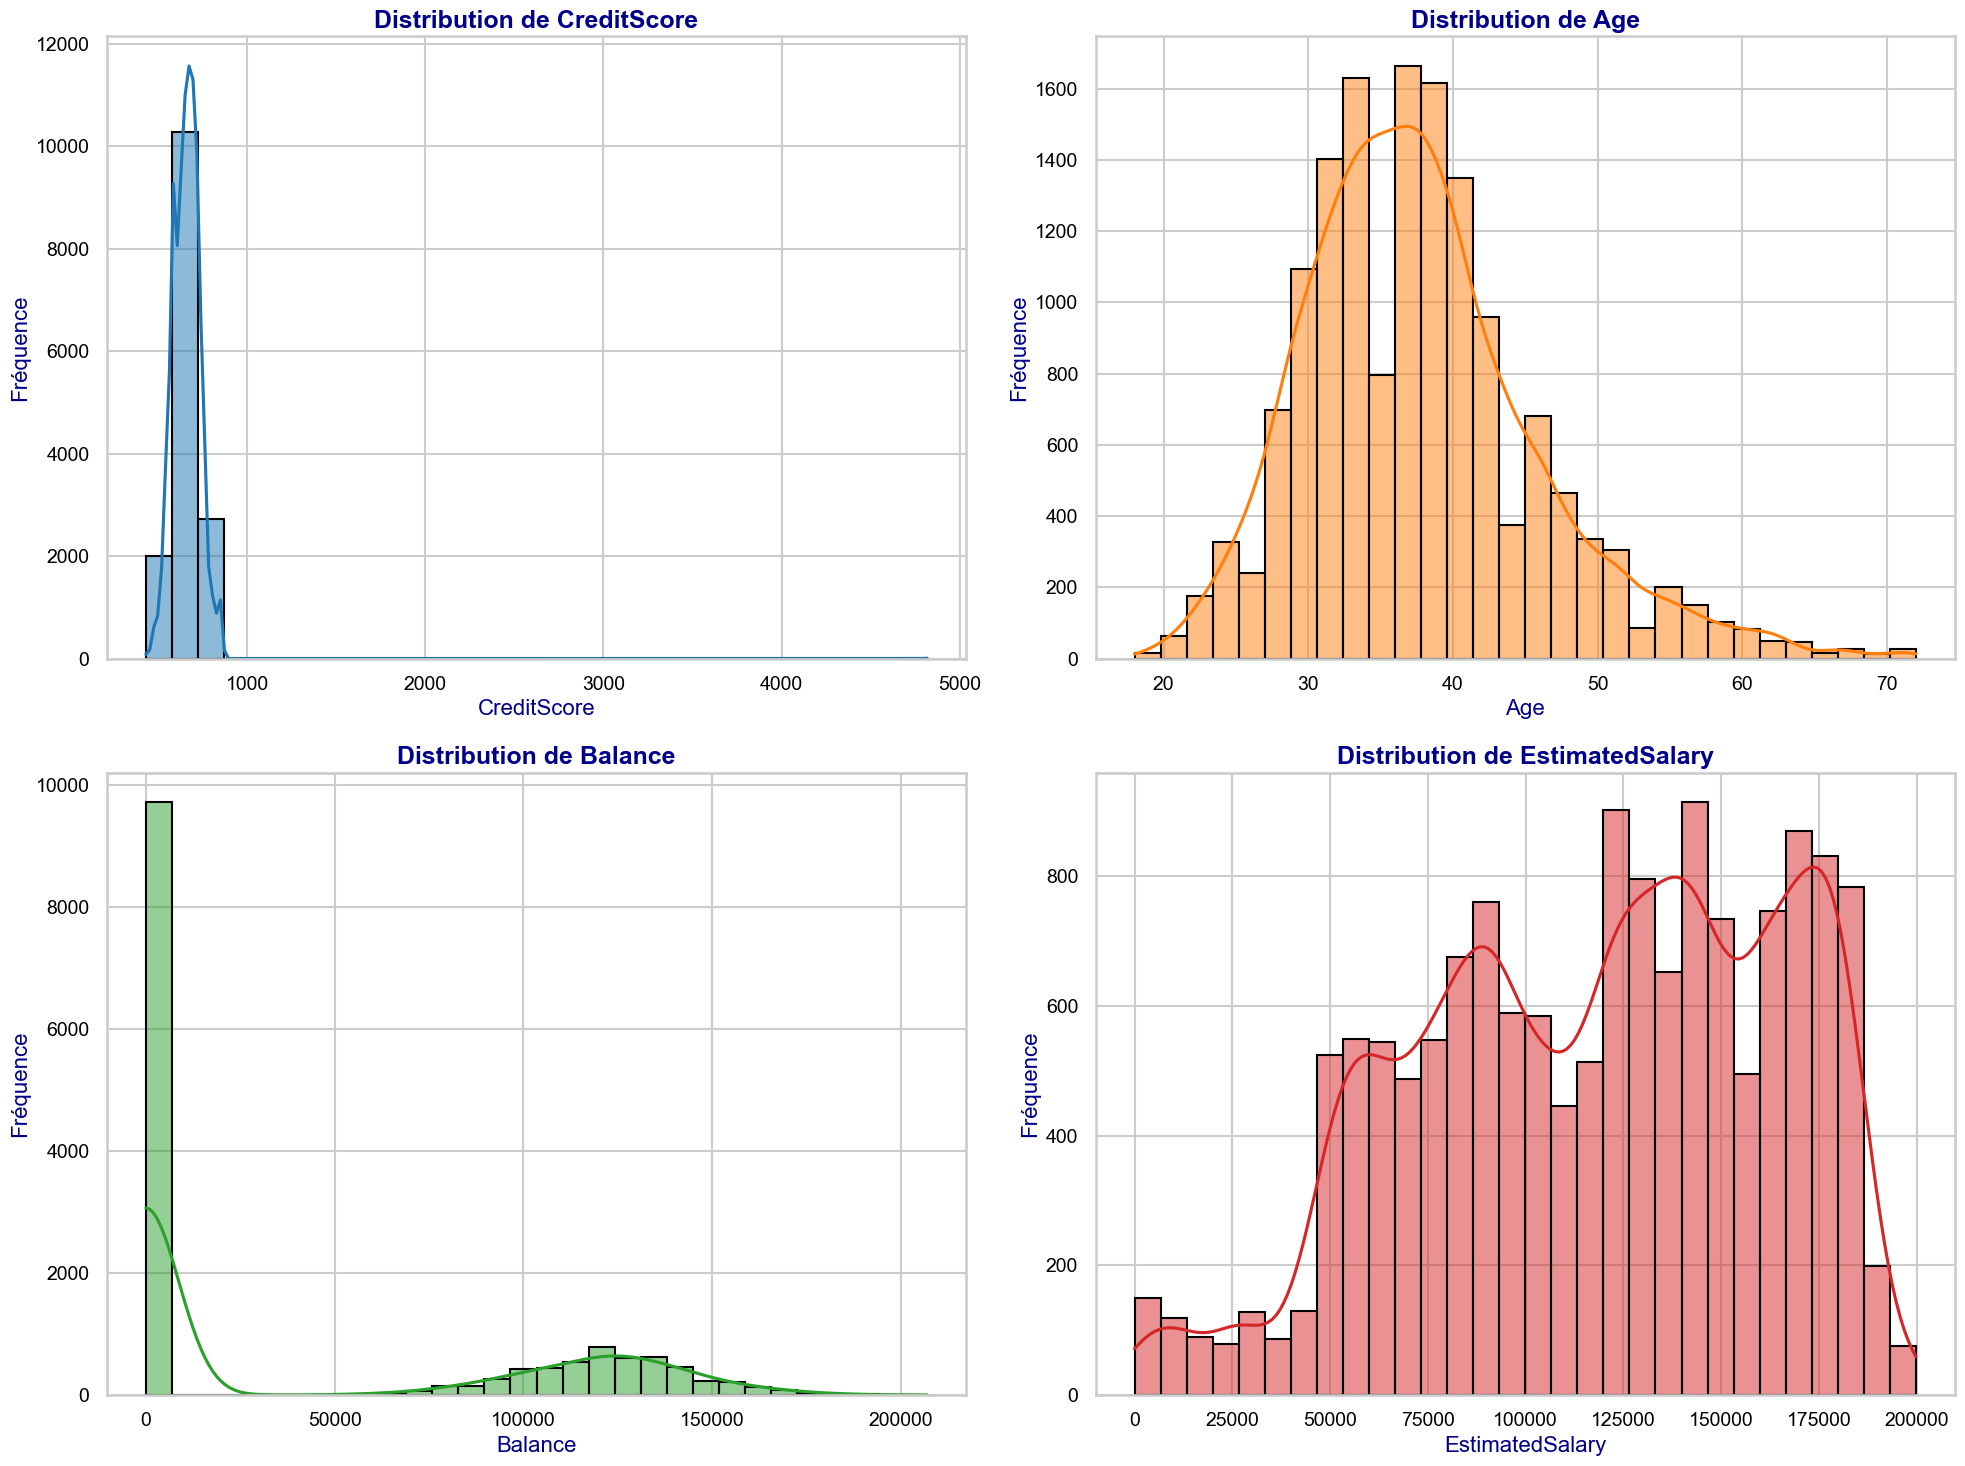

In [388]:
# Distributions des variables continues dans le dataset train 

continuous_columns=["CreditScore","Age","Balance","EstimatedSalary"]
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"] 

sns.set_style("whitegrid")
sns.set_context("talk")  

fig, axes = plt.subplots(2, 2, figsize=(20,15))  
axes = axes.flatten()  


for i, col in enumerate(continuous_columns):
    sns.histplot(
        df[col],
        kde=True, 
        color=palette[i % len(palette)],  
        ax=axes[i],
        bins=30,  
        edgecolor="black"  
    )
    axes[i].set_title(f'Distribution de {col}', fontsize=18, fontweight='bold', color="darkblue")
    axes[i].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i].set_ylabel('Fréquence', fontsize=16, color="darkblue")
    axes[i].tick_params(axis='both', which='major', labelsize=14, colors="black")


fig.patch.set_facecolor('white')  
plt.tight_layout()
plt.show()


In [389]:
# les valeurs les plus grandes de "CreditScore" dans la base de données df
top_10_values = df["CreditScore"].nlargest(10)
print("Les 10 plus grandes valeurs de 'Balance' :\n", top_10_values)

Les 10 plus grandes valeurs de 'Balance' :
 11889    4818.0
110       850.0
184       850.0
190       850.0
219       850.0
245       850.0
313       850.0
365       850.0
862       850.0
897       850.0
Name: CreditScore, dtype: float64


In [390]:
# les valeurs les plus grandes de "CreditScore" dans la base de données test
top_10_values = test_final["CreditScore"].nlargest(10)
print("Les 10 plus grandes valeurs de 'Balance' :\n", top_10_values)

Les 10 plus grandes valeurs de 'Balance' :
 19     850.0
87     850.0
132    850.0
211    850.0
240    850.0
456    850.0
493    850.0
590    850.0
658    850.0
678    850.0
Name: CreditScore, dtype: float64


In [391]:
df[df["CreditScore"]== 4818.0]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
11889,4818.0,France,Female,41.0,1,0.0,2,1,1,73418.29,0


In [392]:
df = df[df["CreditScore"] != 4818.0]

##### On élimine l'observation avec un CreditScore de 4818 dans le train car c'est sûrement une valeur aberrante. Un score de crédit est généralement compris entre 300 et 850 dans la plupart des systèmes d'évaluation, notamment aux États-Unis avec les modèles FICO et VantageScore. 

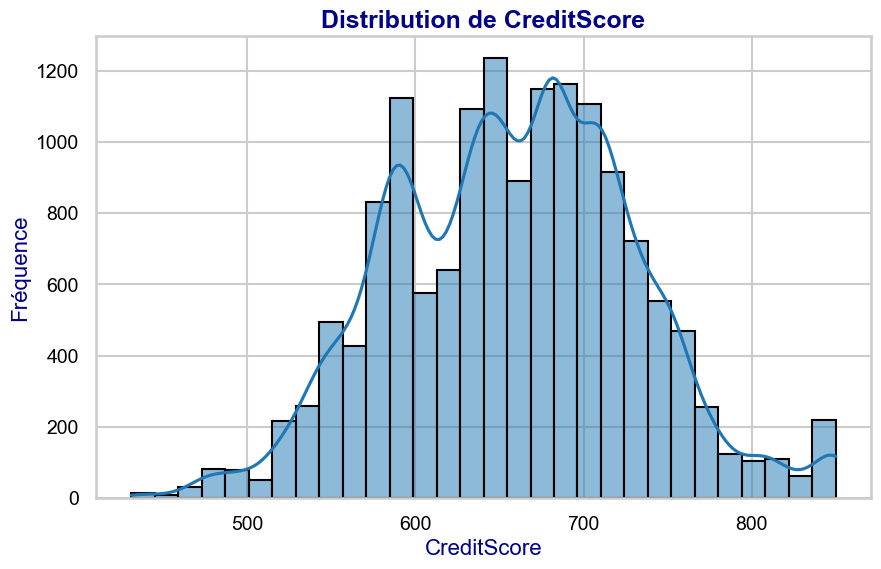

In [393]:
# Distribution pour CreditScore uniquement dans le dataset train : df
plt.figure(figsize=(10, 6))
sns.histplot(
    df["CreditScore"],
    kde=True,
    color=palette[0], 
    bins=30,  
    edgecolor="black"  
)
plt.title("Distribution de CreditScore", fontsize=18, fontweight='bold', color="darkblue")
plt.xlabel("CreditScore", fontsize=16, color="darkblue")
plt.ylabel("Fréquence", fontsize=16, color="darkblue")
plt.tick_params(axis='both', which='major', labelsize=14, colors="black")

plt.show()

##### Après on remarque qu'il y a beaucoup de balances qui sont égales à 0. On a décidé de regarder la distribution de balance en fonction de "IsActiveMember".

In [394]:
balance_zero_counts = df[df["Balance"] == 0]["IsActiveMember"].value_counts()
balance_zero_counts.rename(index={0: "Inactif", 1: "Actif"}, inplace=True)
balance_zero_counts

IsActiveMember
Actif      4875
Inactif    4844
Name: count, dtype: int64

##### Finalement il y a presque la même proportion de gens qui sont actifs et inactifs avec Balance = 0. On ne voit pas de pattern à étudier davantage.

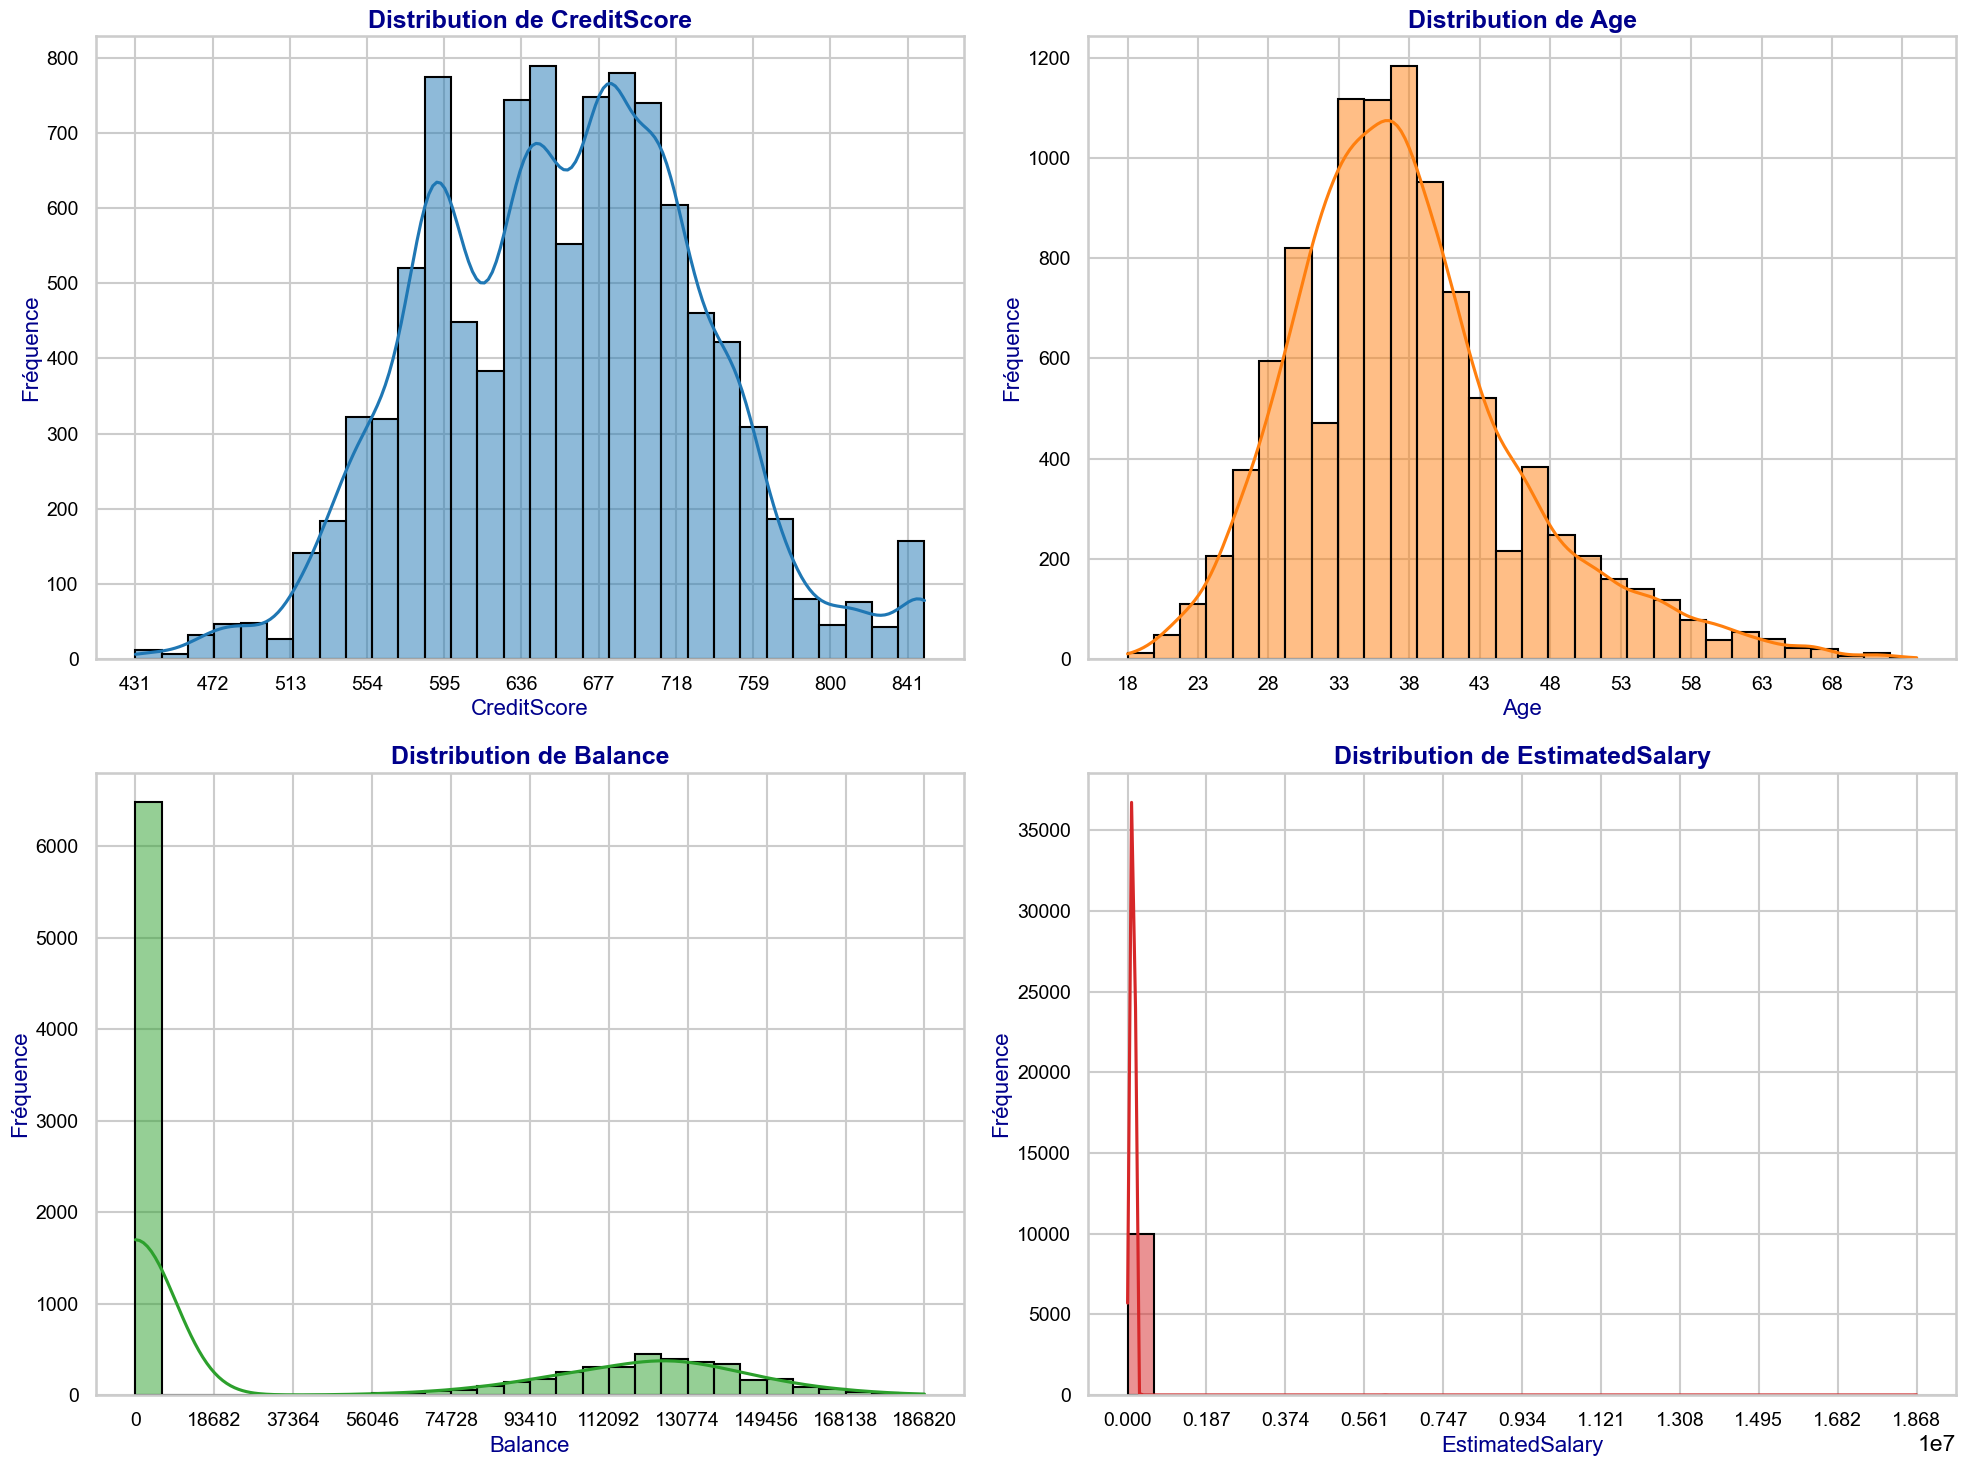

In [395]:
# Distributions pour le test

continuous_columns = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

sns.set_style("whitegrid")
sns.set_context("talk")

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(continuous_columns):
    sns.histplot(
        test_final[col],
        kde=True,
        color=palette[i % len(palette)],
        ax=axes[i],
        bins=30,
        edgecolor="black"
    )
    axes[i].set_title(f'Distribution de {col}', fontsize=18, fontweight='bold', color="darkblue")
    axes[i].set_xlabel(col, fontsize=16, color="darkblue")
    axes[i].set_ylabel('Fréquence', fontsize=16, color="darkblue")
    
    # Ensure x-axis ticks are integers
    if test_final[col].dtype in ['int64', 'float64']:
        min_val = int(test_final[col].min())
        max_val = int(test_final[col].max())
        axes[i].set_xticks(range(min_val, max_val + 1, max(1, (max_val - min_val) // 10))) 
    
    axes[i].tick_params(axis='both', which='major', labelsize=14, colors="black")

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


##### Ici on peut observer qu'il n'y a pas de différences importantes entre les distributions train et test pour les variables considérées numériques, sauf pour la variable "EstimatedSalary". On observe que cette distribution est fortement asymétrique vers la droite, ce qui est dû à deux valeurs extrêmes de 18.7 et de 6 mlns. 

In [396]:
# Les valeurs les plus élevées de "EstimatedSalary" dans train
top_10_values = df["EstimatedSalary"].nlargest(10)
print("Les 10 plus grandes valeurs de 'EstimatedSalary' :\n", top_10_values)

Les 10 plus grandes valeurs de 'EstimatedSalary' :
 9890     199761.29
13039    199753.97
4964     199693.84
2969     199674.83
3205     199674.83
13566    199674.83
85       199661.50
11649    199657.46
1199     199644.20
5203     199644.20
Name: EstimatedSalary, dtype: float64


In [397]:
# Les valeurs les plus élevées de "EstimatedSalary" dans test
top_10_values = test_final["EstimatedSalary"].nlargest(10)
print("Les 10 plus grandes valeurs de 'EstimatedSalary' :\n", top_10_values)

Les 10 plus grandes valeurs de 'EstimatedSalary' :
 4562    18684319.71
1725     6090907.49
8082      199761.29
4628      199693.84
3786      199657.46
5988      199505.53
3041      199493.38
9410      199493.38
8933      199484.96
4835      199454.37
Name: EstimatedSalary, dtype: float64


In [398]:
test_final[test_final['EstimatedSalary']==18684319.71]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
4562,652.0,France,Female,71.0,7,0.0,1,0,1,18684319.71


In [399]:
test_final[test_final['EstimatedSalary']==6090907.49]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1725,588.0,France,Male,37.0,5,160599.06,1,1,0,6090907.49


##### On voit 2 valeurs qui sont trop élevées. Ce sont des valeurs aberrantes. On ne peut pas supprimer les observations des données de test, donc, on a décidé de faire les prévisions pour ces valeurs avec les autres variables. On fera ça après le prétraitement des variables.

## Corrélation

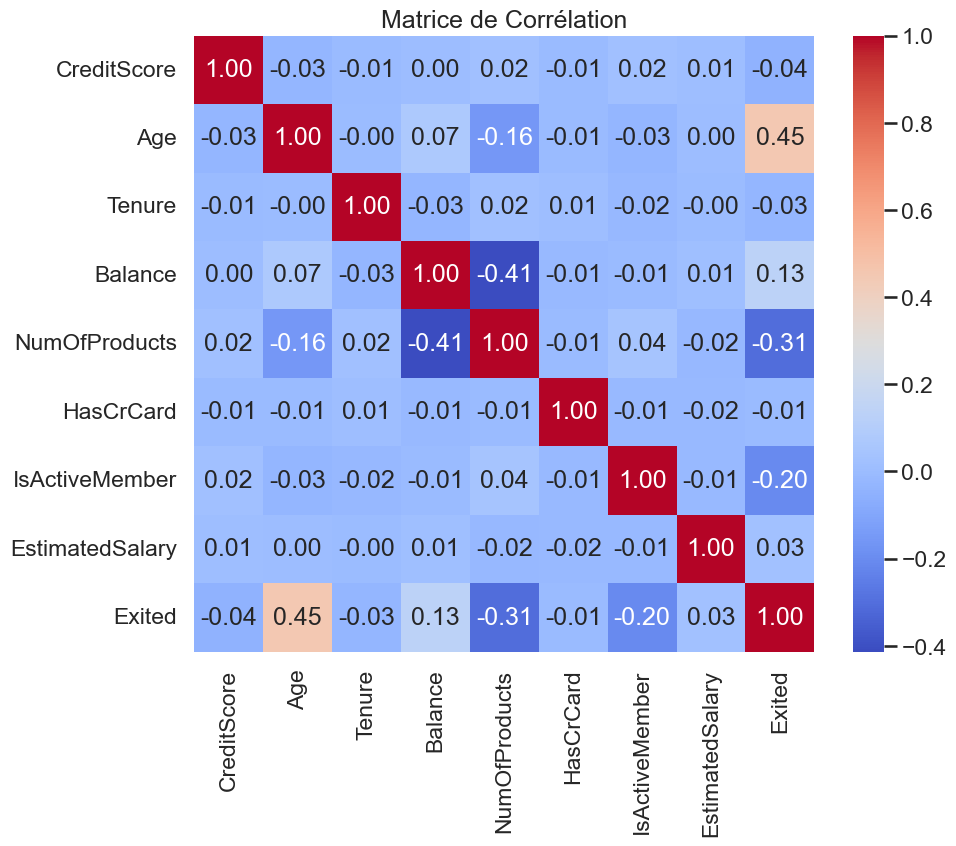

In [400]:
# Matrice de corrélation et affichage sous forme de heatmap dans le train
matrice_corr=df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Matrice de Corrélation')
plt.show()

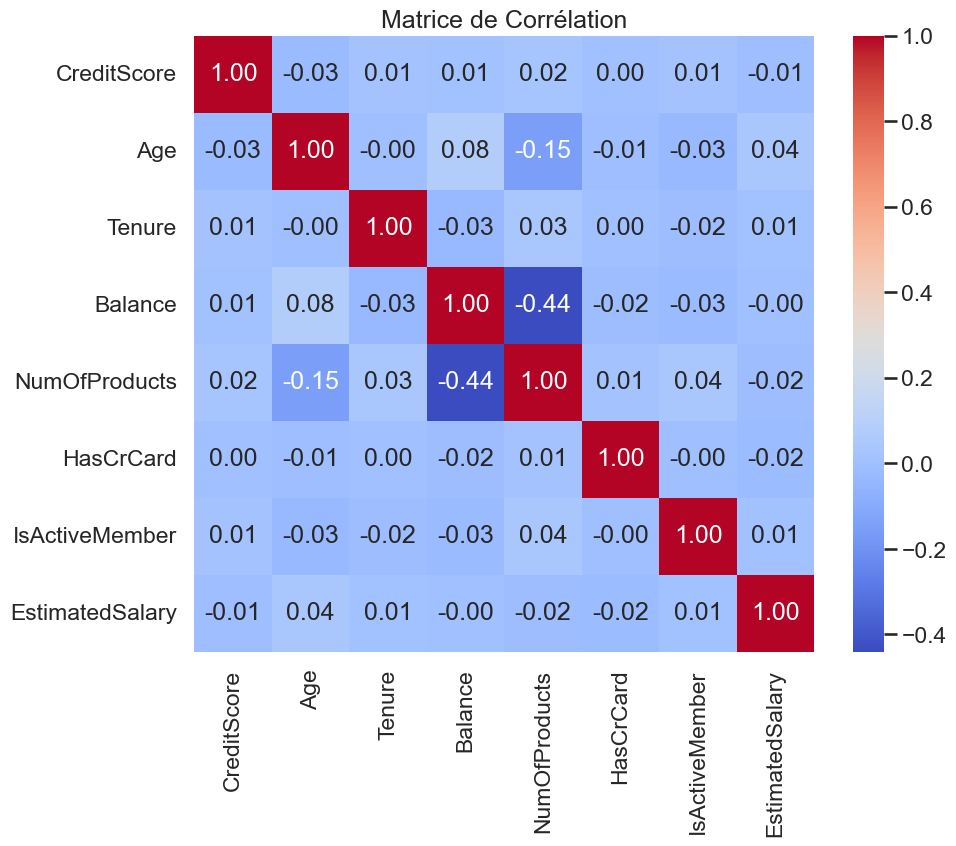

In [401]:
# Matrice de corrélation et affichage sous forme de heatmap dans le test
matrice_corr=test_final[numerical_columns.drop("Exited")].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Matrice de Corrélation')
plt.show()

##### La corrélation reste modérée pour la plupart des couples de variables numériques.

## Outliers

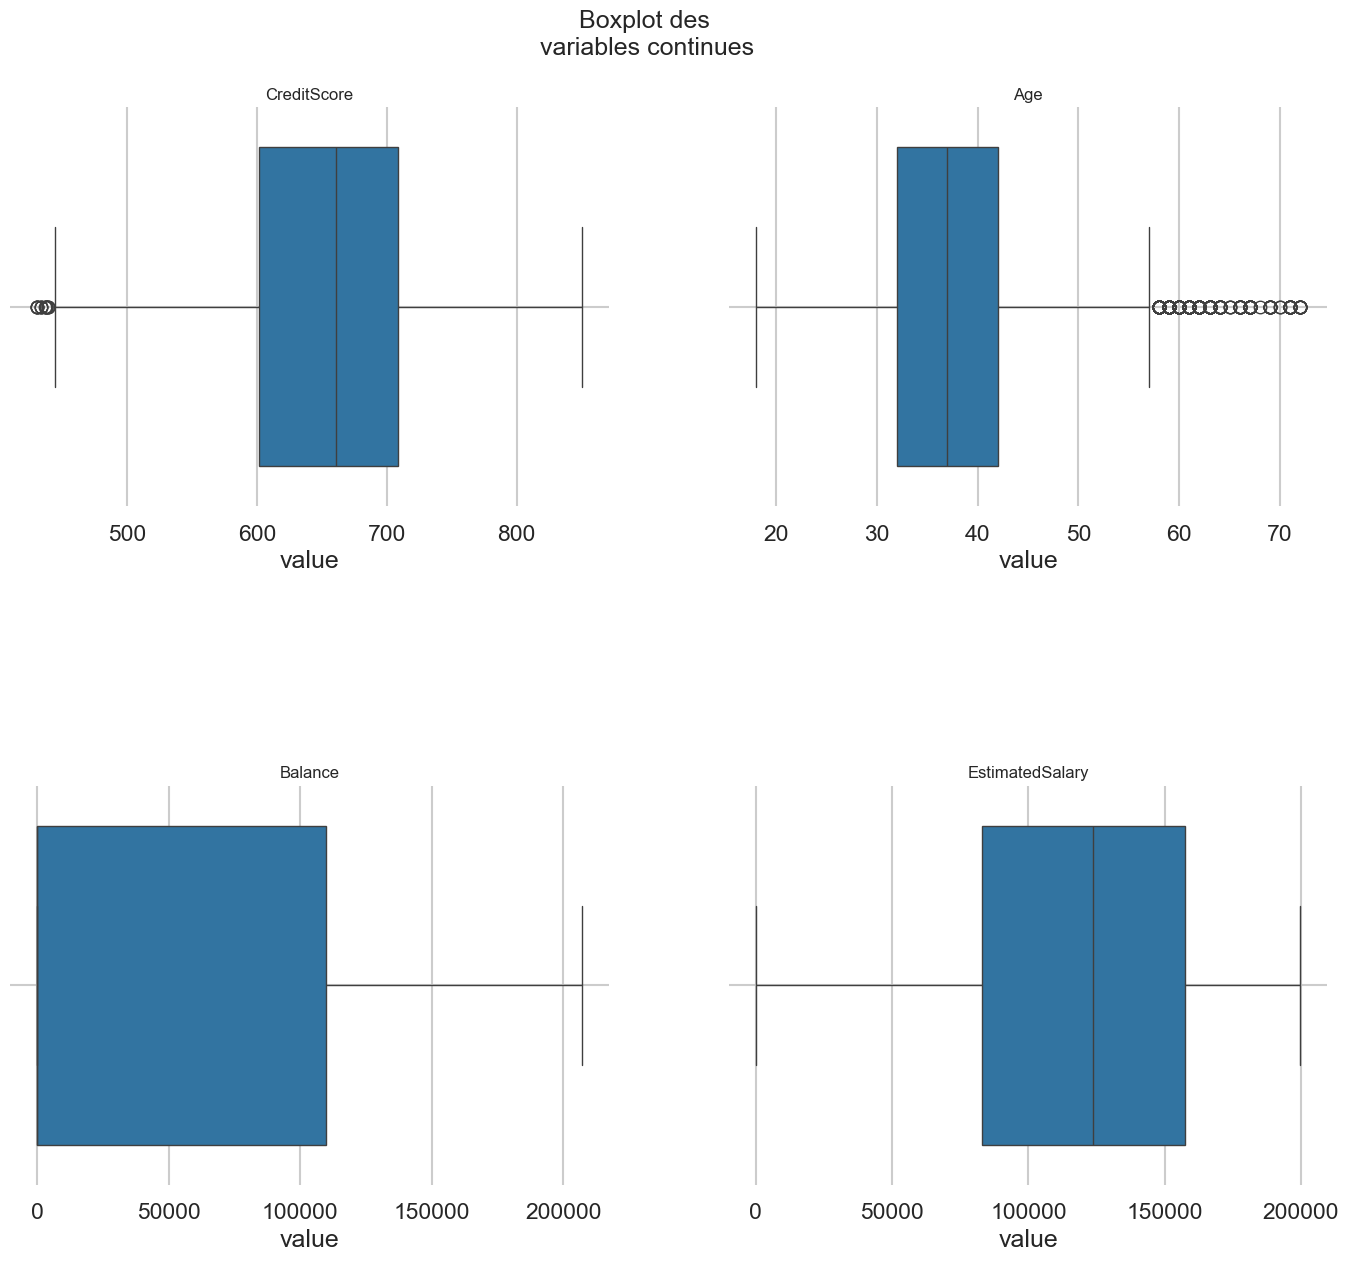

In [402]:
# Pour les données train
cols_to_check = continuous_columns 
temp = pd.melt(df[cols_to_check].reset_index(), id_vars='index', value_vars=cols_to_check).iloc[:, -2:]

ncols = 2 
nrows = len(cols_to_check) // ncols + (len(cols_to_check) % ncols > 0)

plt.figure(figsize=(17, 14))
plt.subplots_adjust(hspace=0.7, wspace=0.2)  
plt.suptitle("Boxplot des \nvariables continues", fontsize=18, y=0.95)

for n, variable in enumerate(cols_to_check):
    ax = plt.subplot(nrows, ncols, n + 1)

    sns.boxplot(
        ax=ax, 
        data=temp[temp['variable'] == variable], 
        x='value', 
        orient='h'
    )
    ax.grid(visible=True, which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_title(variable, loc='center', fontsize=12)

plt.show()


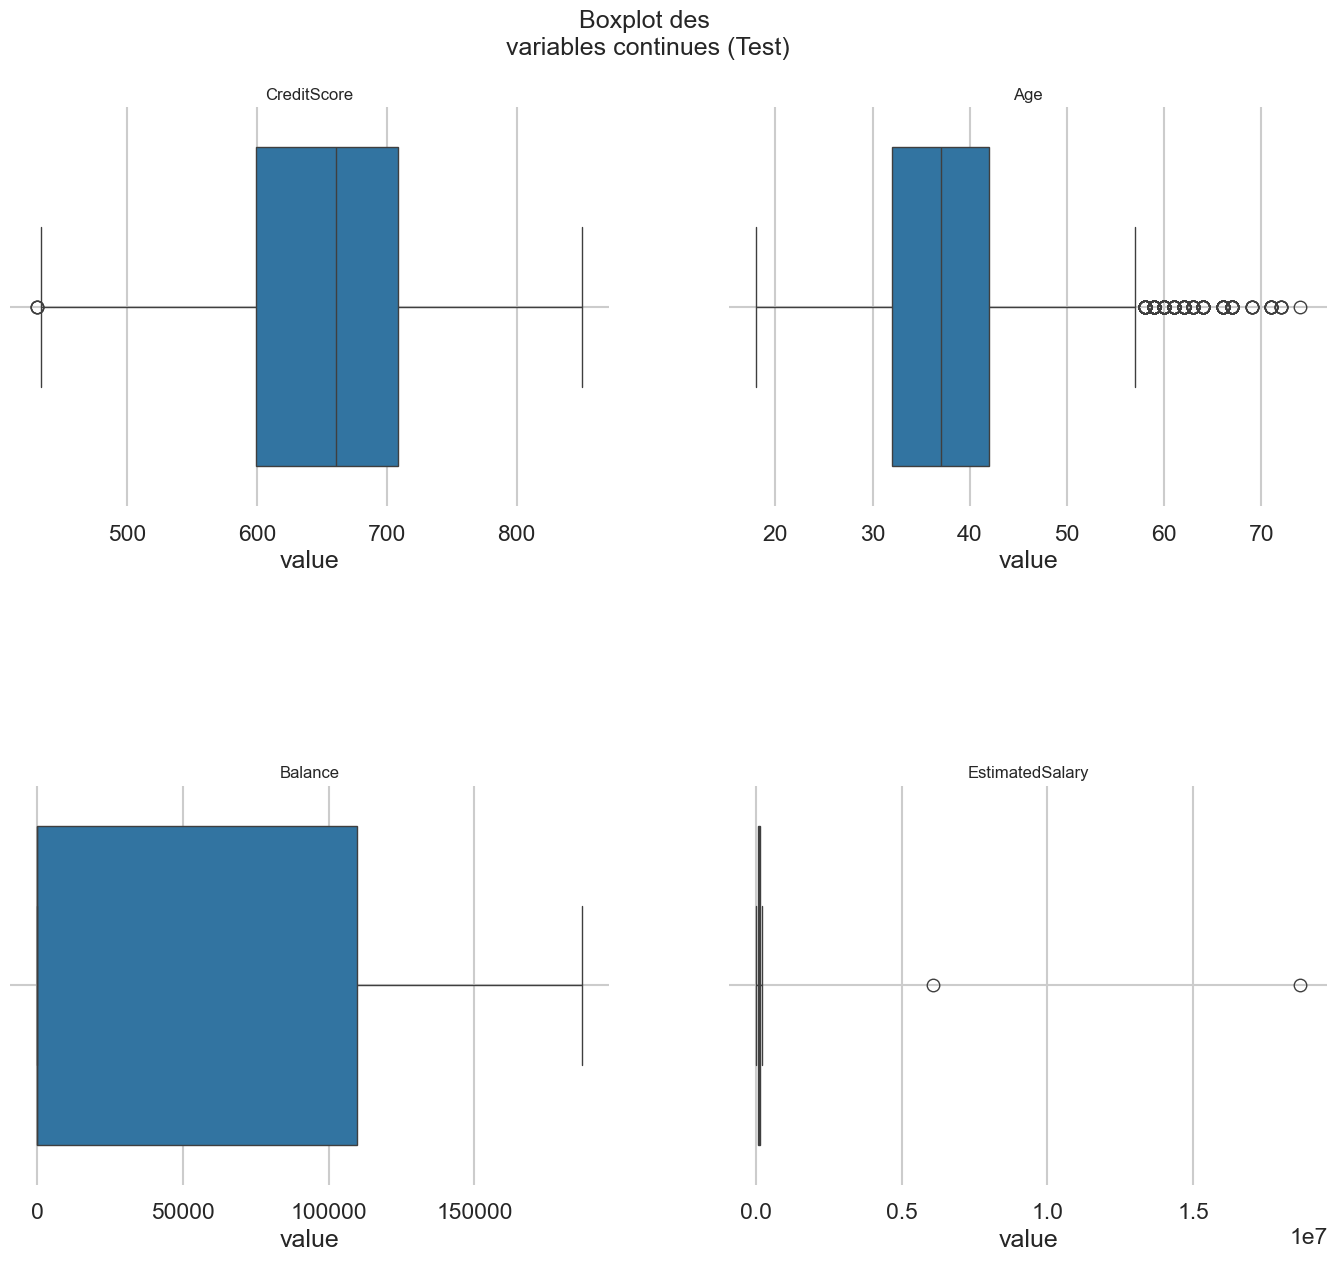

In [403]:
# Pour les données test 
temp_test = pd.melt(test_final[cols_to_check].reset_index(), id_vars='index', value_vars=cols_to_check).iloc[:, -2:]

ncols = 2
nrows = len(cols_to_check) // ncols + (len(cols_to_check) % ncols > 0)

plt.figure(figsize=(17, 14))
plt.subplots_adjust(hspace=0.7, wspace=0.2)  
plt.suptitle("Boxplot des \nvariables continues (Test)", fontsize=18, y=0.95)

for n, variable in enumerate(cols_to_check):
    ax = plt.subplot(nrows, ncols, n + 1)

    sns.boxplot(
        ax=ax, 
        data=temp_test[temp_test['variable'] == variable], 
        x='value', 
        orient='h'
    )
    ax.grid(visible=True, which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_title(variable, loc='center', fontsize=12)

plt.show()


##### On peut voir que les graphiques se ressemblent, il y a certains outliers pour la variable "Age", mais il ne faut pas les supprimer car ce ne sont pas des valeurs aberrantes.

## Prétraitement des données

##### 1. Après la suppression d'une variable dans le DataFrame, il est nécessaire de réinitialiser les index afin de conserver un ordre séquentiel et cohérent.
##### 2. On utilise Target Encoding pour les variables catégorielles qui optimise les performances d'un modèle en exploitant les relations entre les caractéristiques et la variable cible. 
##### 3. On prévoit des valeurs aberrantes du test


In [404]:
#1.
df.reset_index(drop=True, inplace=True)

In [405]:
#2.
# Encodage des variables catégoriques avec TargetEncoder
categorical_features = ['Geography', 'Gender']
encoder = TargetEncoder(cols=categorical_features)
df[categorical_features] = encoder.fit_transform(df[categorical_features], df["Exited"])
test_final[categorical_features] = encoder.transform(test_final[categorical_features])

In [406]:
df.dtypes

CreditScore        float64
Geography          float64
Gender             float64
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [407]:
test_final.dtypes

CreditScore        float64
Geography          float64
Gender             float64
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [408]:
#3.
non_aberrantes = test_final[(test_final["EstimatedSalary"] < 200000.0)]
aberrantes = test_final[(test_final["EstimatedSalary"] > 200000.0)]

##### On sépare l'ensemble de données test en aberrantes et non_aberrantes. On va se servir du dataset non_aberrantes pour prédire la variable "EstimatedSalary" pour les observations aberrantes.

In [409]:
# Ici on a juste les deux observations avec des valeurs aberrantes pour la variable "EstimatedSalary"
aberrantes.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1725,588.0,0.154195,0.139634,37.0,5,160599.06,1,1,0,6090907.49
4562,652.0,0.154195,0.275810,71.0,7,0.00,1,0,1,18684319.71


In [410]:
# train sans valeurs aberrantes
X_train_abb = non_aberrantes.drop("EstimatedSalary", axis=1)
y_train_abb = non_aberrantes["EstimatedSalary"]

X_outliers = aberrantes.drop("EstimatedSalary", axis=1)

model = RandomForestRegressor(random_state=42)
model.fit(X_train_abb, y_train_abb)

# Prédire les valeurs aberrantes
aberrantes = aberrantes.copy() 
predicted_values = model.predict(X_outliers)
aberrantes["EstimatedSalary"] = predicted_values
aberrantes["EstimatedSalary"] = aberrantes["EstimatedSalary"].astype(float)
aberrantes["EstimatedSalary"]=round(aberrantes["EstimatedSalary"],2)

In [411]:
# On remplace les nouvelles valeurs dans test
test_final.loc[aberrantes.index, "EstimatedSalary"] = aberrantes["EstimatedSalary"]

In [412]:
# Vérification
test_final.loc[aberrantes.index]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1725,588.0,0.154195,0.139634,37.0,5,160599.06,1,1,0,95048.76
4562,652.0,0.154195,0.275810,71.0,7,0.00,1,0,1,109720.73


## Feature engineering

##### On crée des variables qui peuvent être pertinentes et peuvent apporter une information utile de par leur interprétation.

In [413]:
# il faut vérifier que "Age" et "EstimatedSalary" ne sont pas égales à 0 (elles sont au dénominateur par la suite)

print(f"minimum pour 'EstimatedSalary' {df['EstimatedSalary'].min()}")
print(f"minimum pour 'Age' {df['Age'].min()}")


minimum pour 'EstimatedSalary' 11.58
minimum pour 'Age' 18.0


In [414]:
 #pour le train
df['Balance_to_Salary_Ratio'] = df['Balance'] / (df['EstimatedSalary'])
df['CreditScore_per_Age'] = df['CreditScore'] / (df['Age'])
df['Tenure_by_Age'] = df['Tenure'] / df['Age']
df['ActiveWithCard'] = df['IsActiveMember'] * df['HasCrCard']
df['Age_Balance_Interaction'] = df['Age'] * df['Balance']
df['CreditScore_NumProducts_Ratio'] = df['CreditScore'] / (df['NumOfProducts'] + 1e-6)

In [415]:

# pour le test
test_final['Balance_to_Salary_Ratio'] = test_final['Balance'] / (test_final['EstimatedSalary'])
test_final['CreditScore_per_Age'] = test_final['CreditScore'] / (test_final['Age'])
test_final['Tenure_by_Age'] = test_final['Tenure'] / test_final['Age']
test_final['ActiveWithCard'] = test_final['IsActiveMember'] * test_final['HasCrCard']
test_final['Age_Balance_Interaction'] = test_final['Age'] * test_final['Balance']
test_final['CreditScore_NumProducts_Ratio'] = test_final['CreditScore'] / (test_final['NumOfProducts'] + 1e-6)

## Standardisation 

##### Le RobustScaler est un outil de mise à l'échelle des données particulièrement adapté aux données contenant des outliers. C'est une méthode de normalisation qui ne dépend pas de la moyenne et de l'écart-type des données, contrairement au StandardScaler. Au lieu de cela, il utilise la médiane et l'écart interquartile pour réduire l'impact des valeurs aberrantes.
##### On effectue la standardisation des ensembles de train et de test séparément de celle des ensembles X_train et X_val afin d'éviter le surapprentissage et les fuites d'information.
##### On fait la standardisation seulement pour les variables numériques continues.

In [416]:
# On normalise la partie test_final en utilisant RobustScaler avec les statistiques calculées sur l'ensemble du df
cols_to_scale = [
    'Balance_to_Salary_Ratio', 'CreditScore_per_Age', 
    'CreditScore_NumProducts_Ratio', 
     'CreditScore', 'Age', 'Balance', 'EstimatedSalary'
     ]

scaler_full = RobustScaler()
scaler_full.fit(df[cols_to_scale])
test_final[cols_to_scale] = scaler_full.transform(test_final[cols_to_scale])

In [417]:
# On normalise la partie train du df après la division train_test_split
X = df.drop("Exited", axis=1) 
y = df["Exited"]              

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

scaler_train = RobustScaler()
scaler_train.fit(X_train[cols_to_scale])

X_train[cols_to_scale] = scaler_train.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler_train.transform(X_val[cols_to_scale])
#Ajout pour scaler aussi l'ensemble du df
df[cols_to_scale]=scaler_train.transform(df[cols_to_scale])          

In [418]:
print("Répartition dans y_train :", y_train.value_counts(normalize=True))
print("Répartition dans y_val :", y_val.value_counts(normalize=True))

Répartition dans y_train : Exited
0    0.800648
1    0.199352
Name: proportion, dtype: float64
Répartition dans y_val : Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64


In [419]:
df_train = pd.DataFrame(X_train)
df_train["Exited"] = y_train
df_train.reset_index(drop=True,inplace=True)

In [420]:
df_test=pd.DataFrame(X_val)
df_test["Exited"] = y_val
df_test.reset_index(drop=True,inplace=True)

In [421]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_to_Salary_Ratio,CreditScore_per_Age,Tenure_by_Age,ActiveWithCard,Age_Balance_Interaction,CreditScore_NumProducts_Ratio,Exited
0,0.877358,0.154195,0.275810,1.4,3,0.000000,2,1,0,-0.783667,0.000000,-0.553806,0.058824,0,0.00,0.025237,1
1,0.216981,0.154195,0.139634,0.1,5,0.000000,2,1,0,0.591507,0.000000,0.026405,0.131579,0,0.00,-0.085174,0
2,0.405660,0.154195,0.139634,0.3,9,0.000000,2,1,1,0.041026,0.000000,-0.045768,0.225000,1,0.00,-0.053628,0
3,-0.424528,0.154195,0.139634,1.8,4,1.392765,1,1,0,-1.011317,4.008935,-1.200529,0.072727,0,8342160.75,0.779180,1
4,-0.320755,0.400742,0.275810,-0.4,3,1.058023,1,1,0,-0.394665,1.554602,0.206836,0.090909,0,3802304.88,0.813880,1


In [422]:
df_test.shape

(4500, 17)

In [423]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_to_Salary_Ratio,CreditScore_per_Age,Tenure_by_Age,ActiveWithCard,Age_Balance_Interaction,CreditScore_NumProducts_Ratio
0,0.207547,0.400742,0.139634,1.2,7,1.137144,2,1,1,0.211719,1,1.127909,-0.706368,0.142857,1,6068055.14,-0.086751
1,-0.500000,0.154195,0.275810,-0.7,10,0.000000,2,1,1,0.319660,0,0.000000,0.435382,0.333333,1,0.00,-0.205048
2,-1.150943,0.154195,0.275810,-0.5,8,0.000000,1,1,1,-0.377929,0,0.000000,-0.182219,0.250000,1,0.00,0.536277
3,-1.235849,0.158121,0.275810,0.2,8,0.000000,2,0,0,0.739063,0,0.000000,-0.769344,0.205128,0,0.00,-0.328076
4,-0.452830,0.154195,0.275810,0.8,10,0.000000,2,1,1,-0.083630,0,0.000000,-0.763484,0.222222,1,0.00,-0.197161


# Modélisation

#### Catboost

##### On a décidé d'utiliser le modèle CatBoost en raison de sa meilleure performance en terme de roc-auc par rapport aux autres modèles qu'on a testés

##### grid search


##### On fait le grid search pour optimiser les hyperparamètres afin d'améliorer le roc auc. Pour faire ça, on utilise Stratified cross-validation qui permet d'évaluer l'impact de différents hyperparamètres sur la performance du modèle en utilisant une méthode systématique.En combinant la cross-validation avec Grid Search on peut trouver les meilleures configurations pour le modèle.

##### !!!!!On a mis les grilles pour l'optimisation des hyperparamètres et intégré directement les hyperparamètres optimaux trouvés, afin d'éviter un temps d'exécution prolongé lié au lancement du processus d'optimisation. !!!!!

In [424]:
# param_grid = {
#     'iterations': [1000, 1500],
#     'learning_rate': [0.01, 0.03, 0.05],
#     'depth': [ 6, 8, 10],
#     'l2_leaf_reg': [3, 5, 7]
# }

In [425]:
#model = CatBoostClassifier(verbose=0, random_state=42)

In [426]:
# Stratified K-Fold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=5, verbose = 1)

In [427]:
#grid_search.fit(X_train, y_train)

##### On fait l'entrainement sur X_train et y_train pour préserver l'overfitting quand on fait la cross validation 

In [428]:
#best_model = grid_search.best_estimator_

In [429]:
#best_parameters = grid_search.best_params_

In [430]:
#print("Meilleur ROC-AUC:", grid_search.best_score_)

In [431]:
#print("Meilleurs hyperparamètres:", best_parameters)

In [432]:
best_model = CatBoostClassifier(depth= 6, iterations=1000, l2_leaf_reg=7, learning_rate=0.01, verbose=0, random_state=42)

In [433]:
best_model.fit(X_train, y_train)

In [434]:
# Prédire les probabilités et calculer le roc-auc
y_pred_prob = best_model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_prob)

print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.9324


##### La première vérification sur l'ensemble de validation

## k-fold vérification

##### On utilise la validation croisée stratifiée, qui divise les données en plusieurs sous-ensembles tout en conservant la proportion des classes dans chaque fold. Cela garantit que le modèle est évalué sur des données qu'il n'a pas vues pendant l'entraînement, tout en respectant la distribution des classes.

In [435]:
# On divise le df en 5 folds avec la même distribution de variable "Exited"
NB_SPLIT = 5 
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=100)


df["stratify_group"] = df[["Exited"]].astype(str).agg("_".join, axis=1)

df["fold"] = -1
for fold, (trn_, val_) in enumerate(skf.split(df, df["stratify_group"])):
    df.loc[val_, "fold"] = fold

# Supression d'une colonne temporelle
df.drop(columns=["stratify_group"], inplace=True)

print(df["fold"].value_counts())

fold
3    3000
2    3000
0    3000
1    3000
4    2999
Name: count, dtype: int64


In [436]:
# On vérifie les proportions dans chaque fold
for fold in range(NB_SPLIT):
    print(f"Fold {fold}:")
    print(df[df['fold'] == fold]['Exited'].value_counts(normalize=True))
    print()

Fold 0:
Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64

Fold 1:
Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64

Fold 2:
Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64

Fold 3:
Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64

Fold 4:
Exited
0    0.8006
1    0.1994
Name: proportion, dtype: float64



In [437]:
X_avec_fold = df.drop(columns=["Exited"])
y_avec_fold = df.Exited

In [438]:
auc_scores = []  
for fold in X_avec_fold["fold"].unique():
    print(f"Fold {fold + 1}")

    train_idx = X_avec_fold["fold"] != fold
    test_idx = X_avec_fold["fold"] == fold
    
    X_fold_train = X_avec_fold.loc[train_idx].drop("fold", axis=1)
    X_fold_test = X_avec_fold.loc[test_idx].drop("fold", axis=1)
    y_fold_train = y_avec_fold[train_idx]
    y_fold_test = y_avec_fold[test_idx]

    best_model.fit(X_fold_train, y_fold_train)
    
    y_pred_prob = best_model.predict_proba(X_fold_test)[:, 1]
    
    # Calculer le ROC-AUC
    auc = roc_auc_score(y_fold_test, y_pred_prob)
    auc_scores.append(auc)
    print(f"ROC-AUC for Fold {fold + 1}: {auc:.4f}")

mean_auc = np.mean(auc_scores)
print(f"\nMean ROC-AUC: {mean_auc:.4f}")

Fold 4
ROC-AUC for Fold 4: 0.9368
Fold 3
ROC-AUC for Fold 3: 0.9353
Fold 1
ROC-AUC for Fold 1: 0.9447
Fold 5
ROC-AUC for Fold 5: 0.9335
Fold 2
ROC-AUC for Fold 2: 0.9375

Mean ROC-AUC: 0.9376


##### Le but de notre analyse était de minimiser la variance entre les roc-auc de chaque fold et en même temps de maximiser le roc_auc moyen.

# Application

In [439]:
# On prend l'ensemble des données fournies pour l'entraînement 
X = df.drop(columns=["Exited", "fold"])
y = df["Exited"]

In [440]:
best_model.fit(X,y)

In [441]:
y_pred_prob = best_model.predict_proba(test_final)[:, 1]

In [442]:
y_pred_prob = pd.DataFrame(y_pred_prob, columns=["Exited"])

In [443]:
y_pred_prob["id"]=test_final_for_id["id"]

In [444]:
y_pred_prob=y_pred_prob[['id', 'Exited']]

In [445]:
y_pred_prob.to_csv("catboostgrid.csv", index = False)

# Prévision avec 5 modèles k-fold et la moyenne

##### Le principe est d'utiliser cross-validation pour prédire les probabilités, on reçoit 5 prévisions de 5 modèles et on calcule la moyenne de ces 5 prévisions.
#### Le premier étape est de calculer ROC AUC pour les prévisions moyennes sur X_train et y_train et après de le refaire avec train entier

In [446]:
# On divise le df en 5 folds avec la même distribution de variable "Exited"
NB_SPLIT = 5 
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=100)


df["stratify_group"] = df[["Exited"]].astype(str).agg("_".join, axis=1)

df["fold"] = -1
for fold, (trn_, val_) in enumerate(skf.split(df, df["stratify_group"])):
    df.loc[val_, "fold"] = fold

# Supression d'une colonne temporelle
df.drop(columns=["stratify_group"], inplace=True)

print(df["fold"].value_counts())

fold
3    3000
2    3000
0    3000
1    3000
4    2999
Name: count, dtype: int64


In [447]:
X_for_cv = df.drop("Exited", axis=1) 
y = df["Exited"]              

X_train, X_val, y_train, y_val = train_test_split(
    X_for_cv, y, test_size=0.3, stratify=y, random_state=0
)

In [448]:
n_splits = 5
models = []
test_predictions = np.zeros((X_val.shape[0], n_splits))  
fold_roc_auc_scores = []

for fold in range(n_splits):
    print(f"Fold {fold + 1}")
    
    # Séparer les indices pour ce fold
    train_idx = X_train[X_train["fold"] != fold].index
    val_idx = X_train[X_train["fold"] == fold].index

    X_fold_train, y_fold_train = X_train.loc[train_idx], y_train.loc[train_idx]
    X_fold_val, y_fold_val = X_train.loc[val_idx], y_train.loc[val_idx]

    
    best_model.fit(X_fold_train, y_fold_train, eval_set=(X_fold_val, y_fold_val), early_stopping_rounds=50, verbose=0)
    models.append(best_model)
    

    test_predictions[:, fold] = best_model.predict_proba(X_val)[:, 1]
    
    val_preds = best_model.predict_proba(X_fold_val)[:, 1]
    fold_roc_auc = roc_auc_score(y_fold_val, val_preds)
    fold_roc_auc_scores.append(fold_roc_auc)
    print(f"ROC AUC pour le fold {fold + 1}: {fold_roc_auc:.4f}")


average_test_predictions = test_predictions.mean(axis=1)

# Calculer le ROC AUC pour les prédictions moyennes
average_roc_auc = roc_auc_score(y_val, average_test_predictions)
print(f"ROC AUC moyen sur les folds: {np.mean(fold_roc_auc_scores):.4f}")
print(f"ROC AUC pour les prédictions moyennes: {average_roc_auc:.4f}")

Fold 1
ROC AUC pour le fold 1: 0.9485
Fold 2
ROC AUC pour le fold 2: 0.9369
Fold 3
ROC AUC pour le fold 3: 0.9340
Fold 4
ROC AUC pour le fold 4: 0.9388
Fold 5
ROC AUC pour le fold 5: 0.9365
ROC AUC moyen sur les folds: 0.9389
ROC AUC pour les prédictions moyennes: 0.9324


### sur les données test

In [449]:
X_avec_fold = df.drop(columns=["Exited"])

In [450]:
n_splits = 5
models = []
test_predictions = np.zeros((test_final.shape[0], n_splits))
fold_roc_auc_scores = []

for fold in range(n_splits):
    print(f"Fold {fold + 1}")
    
    # Séparer les indices pour ce fold
    train_idx = X_avec_fold[X_avec_fold["fold"] != fold].index
    val_idx = X_avec_fold[X_avec_fold["fold"] == fold].index
    
    # Créer les ensembles de train et test
    X_fold_train, y_fold_train = X_avec_fold.loc[train_idx], y.loc[train_idx]
    X_fold_val, y_fold_val = X_avec_fold.loc[val_idx], y.loc[val_idx]

    X_fold_train = X_fold_train.drop(columns=["fold"])


    best_model.fit(X_fold_train, y_fold_train)
    models.append(best_model)

    test_predictions[:, fold] = best_model.predict_proba(test_final)[:, 1]

average_test_predictions = test_predictions.mean(axis=1)


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [451]:
average_test_predictions

array([0.09342452, 0.01534416, 0.0099143 , ..., 0.01092423, 0.06748143,
       0.24591697])

# Application

In [452]:
y_pred_prob = pd.DataFrame(average_test_predictions, columns=["Exited"])

In [453]:
y_pred_prob["id"]=test_final_for_id["id"]

In [454]:
y_pred_prob=y_pred_prob[['id', 'Exited']]

In [455]:
y_pred_prob.to_csv("mean_k_fold.csv", index = False)

## prévision avec permutation importance

##### La méthode de Permutation Importance est utilisée pour identifier les variables ayant le plus d'impact sur les performances de notre modèle. Cette technique consiste à mesurer la diminution de la performance du modèle après avoir permuté aléatoirement les valeurs d'une variable spécifique, tout en laissant les autres inchangées.

                          Feature  Importance_Mean  Importance_Std
6                   NumOfProducts         0.052937        0.001719
3                             Age         0.052381        0.001178
1                       Geography         0.017913        0.000630
15  CreditScore_NumProducts_Ratio         0.016448        0.000800
8                  IsActiveMember         0.015183        0.000414
2                          Gender         0.007455        0.000498
11            CreditScore_per_Age         0.006452        0.000454
10        Balance_to_Salary_Ratio         0.005067        0.000357
14        Age_Balance_Interaction         0.005044        0.000306
5                         Balance         0.004228        0.000306
9                 EstimatedSalary         0.002153        0.000116
12                  Tenure_by_Age         0.002117        0.000133
0                     CreditScore         0.001774        0.000074
4                          Tenure         0.001444        0.00

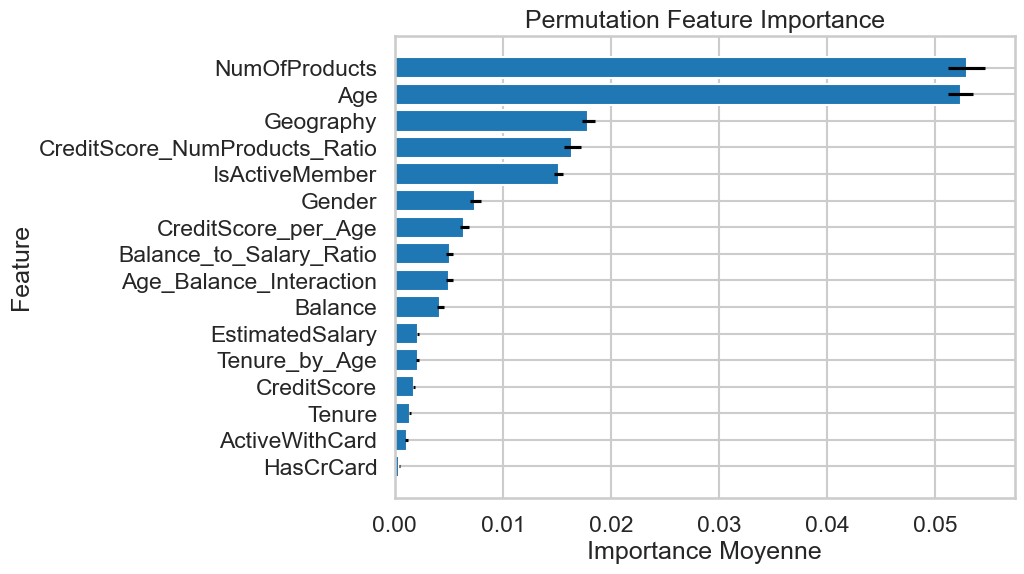

In [456]:
perm_importance = permutation_importance(
    best_model, X, y, scoring='roc_auc', n_repeats=20, random_state=42
)

# Créer un DataFrame pour afficher les résultats
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

print(importance_df)

#Visualisation
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'])
plt.xlabel('Importance Moyenne')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

##### On laisse uniquement les variables utiles pour la prévision

In [457]:
X2 = X.drop(columns=["EstimatedSalary", "Tenure_by_Age", "HasCrCard", "CreditScore",'Tenure', "ActiveWithCard"])

In [458]:
test2 = test_final.drop(columns=["EstimatedSalary", "Tenure_by_Age", "HasCrCard", "CreditScore",'Tenure', "ActiveWithCard" ])

In [459]:
# division en train test
X2_train, X2_val, y_train, y_val = train_test_split(
    X2, y, test_size=0.3, stratify=y, random_state=0
)

## catboost

##### On refait le grid search pour trouver les hyperparamètres optimaux une fois les variables enlevées

### grid search


In [828]:
# param_grid = {
#     'iterations': [1000, 1500],
#     'learning_rate': [ 0.001, 0.01, 0.05],
#     'depth': [ 6, 8, 10],
#     'l2_leaf_reg': [3, 5, 7]
# }

In [829]:
#model =CatBoostClassifier(verbose=0, random_state=42)

In [830]:
# Stratified K-Fold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring='roc_auc', n_jobs=5, verbose = 1)

In [831]:
#grid_search.fit(X2_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x16fe75550>,
             n_jobs=5,
             param_grid={'depth': [6, 8, 10], 'iterations': [1000, 1500],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.001, 0.01, 0.05]},
             scoring='roc_auc', verbose=1)

In [832]:
#best_model2 = grid_search.best_estimator_

In [833]:
#best_parameters2 = grid_search.best_params_

In [834]:
#print("Meilleur ROC-AUC:", grid_search.best_score_)

Meilleur ROC-AUC: 0.9380728887289627


In [835]:
#print("Meilleurs hyperparamètres:", grid_search.best_params_)

Meilleurs hyperparamètres: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 7, 'learning_rate': 0.01}


In [460]:
best_model2 = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg = 7, learning_rate = 0.01, verbose=0, random_state=42)

In [461]:
best_model2.fit(X2_train, y_train)

In [462]:
# Prédire les probabilités et calculer le roc-auc
y_pred_prob = best_model2.predict_proba(X2_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_prob)

print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.9333


## k-fold vérification

In [463]:
# diviser df par 5 fold avec la même distribution de variable "Exited"
NB_SPLIT = 5
skf = StratifiedKFold(n_splits=NB_SPLIT, shuffle=True, random_state=100)


df["stratify_group"] = df[["Exited"]].astype(str).agg("_".join, axis=1)

df["fold"] = -1
for fold, (trn_, val_) in enumerate(skf.split(df, df["stratify_group"])):
    df.loc[val_, "fold"] = fold

#Supression d'une colonne temporelle
df.drop(columns=["stratify_group"], inplace=True)

print(df["fold"].value_counts())

fold
3    3000
2    3000
0    3000
1    3000
4    2999
Name: count, dtype: int64


In [464]:
X2["fold"]= df["fold"]

In [465]:
# Calcule de roc_auc pour chaque fold
auc_scores = []
for fold in X2["fold"].unique():
    print(f"Fold {fold + 1}")

    train_idx = X2["fold"] != fold
    test_idx = X2["fold"] == fold
    
    X_fold_train = X2.loc[train_idx].drop("fold", axis=1)
    X_fold_test = X2.loc[test_idx].drop("fold", axis=1)
    y_fold_train = y[train_idx]
    y_fold_test = y[test_idx]

    best_model2.fit(X_fold_train, y_fold_train)
    
    y_pred_prob = best_model2.predict_proba(X_fold_test)[:, 1]
    
    # Calculer le ROC-AUC
    auc = roc_auc_score(y_fold_test, y_pred_prob)
    auc_scores.append(auc)
    print(f"ROC-AUC for Fold {fold + 1}: {auc:.4f}")

mean_auc = np.mean(auc_scores)
print(f"\nMean ROC-AUC: {mean_auc:.4f}")


Fold 4
ROC-AUC for Fold 4: 0.9370
Fold 3
ROC-AUC for Fold 3: 0.9343
Fold 1
ROC-AUC for Fold 1: 0.9442
Fold 5
ROC-AUC for Fold 5: 0.9323
Fold 2
ROC-AUC for Fold 2: 0.9381

Mean ROC-AUC: 0.9372


#### on voit que la variation augmente un peu, alors que le score moyen diminue un peu. Par contre, cette différence n'est pas très significative.

# Application

In [230]:
X2.drop(columns=["fold"], inplace=True)

In [231]:
best_model2.fit(X2,y)

In [232]:
y_pred_prob = best_model2.predict_proba(test2)[:, 1]

In [233]:
y_pred_prob = pd.DataFrame(y_pred_prob, columns=["Exited"])

In [234]:
y_pred_prob["id"]=test_final_for_id["id"]

In [235]:
y_pred_prob=y_pred_prob[['id', 'Exited']]

In [236]:
y_pred_prob.to_csv("permutation_cat.csv", index = False)

##### Finalement, on a décidé d'utiliser les 2 premières approches, mais on a laissé de côté la Permutation Importance au vu de sa performance.